# Import Dependencies



In [ ]:
import os
import math

from scipy.stats import zscore
import numpy as np
import pandas as pd
import json
import glob
# import lib pprint
from tqdm import tqdm

import matplotlib.pyplot as plt 

import seaborn as sns

from itertools import chain

%pylab inline

sns.set_style('darkgrid')

Populating the interactive namespace from numpy and matplotlib


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Introduction
This study aims to find out **“How are DOH’s tweets perceived by the public?”**

So we will be studying the tweets of DOH to discover how they fare with fellow Filipinos on Twitter, finding out which are the most popular, and what made them popular. In a previous network analysis, we discovered through the out-degree centrality measure one particularly influential Philippine-based health organization — the World Health Organization Philippines (@WHOph) — and an influential non-organization Filipino account on the network — a health professional called Dr Tony (@DrTonyLeachon). As we wish to see how DOH stands compared to other influential Twitter accounts, we will be comparing DOH (@DOHgovph) to WHO PH and Dr Tony.




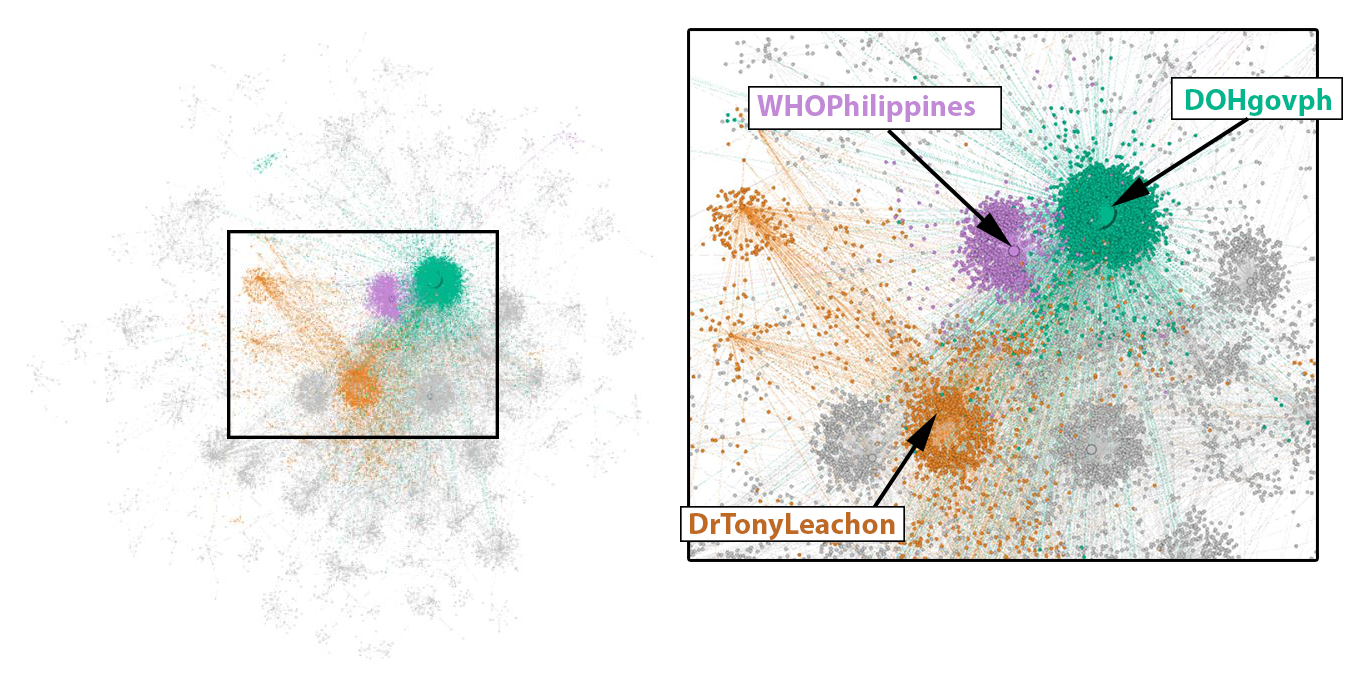


Here, we lay out the specific questions we seek to answer:


- Q1: Which tweets of DOH are the most popular?
- Q2: What are the characteristics of popular DOH tweets?
- Q3: Do the tweets of DOH gain more traction compared to that of other influential users?
-Q4: What are the sentiments of the replies and quoted tweets to the DOH tweets?

# Preprocessing

## Isolating DOH, WHO, Dr. Tony Tweets
Since the data is divided per day because of the crawling process, we want to combine all the data into one data so that we can get all the DOH tweets from the beginning of the crawling, December, up until April. These way, we can further analyze the tweets of DOH. We loop through all the files and append it in to a single dataframe. We make sure to remove all the duplicates that might have occur in multiple days. We sorted the data by date they were created for readability purpose.


In [ ]:
path_ho_list = glob.glob(f'/content/drive/Shareddrives/FOURTUNATE/AY 2020-2021 Term 2/DATASCI/DATASCI Final Project/Final Project Files/Dataset/HO Nodes/*.csv')

In [ ]:
nodes = None

for path in tqdm(path_ho_list):
  if isinstance(nodes, pd.DataFrame):
    dataframe = pd.read_csv(path)
    nodes = nodes.append(dataframe, ignore_index=True)
  else:
    nodes = pd.read_csv(path)

# sort by date and removing duplicates
nodes = nodes.sort_values(['created_at'], ascending=False)
nodes = nodes.drop_duplicates(subset='tweet_id', keep='first', inplace=False)
print('Total data: {}'.format(len(nodes.index)))
nodes.head()

 59%|█████▉    | 77/130 [01:21<01:27,  1.64s/it]/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
 69%|██████▉   | 90/130 [01:43<01:12,  1.80s/it]/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
100%|██████████| 130/130 [02:57<00:00,  1.36s/it]


Total data: 25120


,tweet_id,user_id,user_screen_name,full_text,created_at,retweet_count,favorite_count,retweeted,favorited,possibly_sensitive,truncated,in_reply_to_screen_name,in_reply_to_status_id_str,in_reply_to_user_id_str,is_quote_status,quoted_status_id_str,quoted_user_id_str,retweeted_status_id_str,retweeted_user_id_str,media,hashtags,lang,place,root_node,keyword,crawled_date,crawled_time
2090564,1377278222077988865,35734422,anpapri,RT @WHOPhilippines: Healing hands and a caring...,Wed Mar 31 15:14:51 +0000 2021,34,0,False,False,NaN,False,NaN,NaN,NaN,False,NaN,NaN,1.377086e+18,2.218027e+09,NaN,False,en,NaN,1377085583462264834,covid,2021-03-31,23:16:13
2090565,1377266967409664009,201225629,msneri27,RT @WHOPhilippines: Healing hands and a caring...,Wed Mar 31 14:30:08 +0000 2021,34,0,False,False,NaN,False,NaN,NaN,NaN,False,NaN,NaN,1.377086e+18,2.218027e+09,NaN,False,en,NaN,1377085583462264834,covid,2021-03-31,23:16:13
2090110,1377266011779473410,127438313,alabangbulletin,"RT @DOHgovph: DOH Technical Advisory Group, Dr...",Wed Mar 31 14:26:20 +0000 2021,5,0,False,False,NaN,False,NaN,NaN,NaN,False,NaN,NaN,1.377245e+18,1.863474e+08,NaN,False,en,NaN,1377245337648132101,NaN,2021-03-31,22:46:06
2090522,1377259470804316167,1210245420888182785,LaurenceSon15,RT @DOHgovph: Colorectal Cancer (CRC) is a pre...,Wed Mar 31 14:00:20 +0000 2021,5,0,False,False,NaN,False,NaN,NaN,NaN,False,NaN,NaN,1.377139e+18,1.863474e+08,NaN,False,en,NaN,1377138629881909250,NaN,2021-03-31,23:16:13
2089573,1377259361496559616,1210245420888182785,LaurenceSon15,"RT @DOHgovph: Ngayong 4 PM, Marso 31, 2021, an...",Wed Mar 31 13:59:54 +0000 2021,49,0,False,False,NaN,False,NaN,NaN,NaN,False,NaN,NaN,1.377178e+18,1.863474e+08,NaN,False,tl,NaN,1377177669003923457,covid-19,2021-03-31,22:01:35


In here, we want to see the list of user that interacted with the Health Organization, and the health organization themselves. Together with the number of tweets, whether tweet, retweet, quote tweet, or reply.

In [ ]:
temp = nodes['user_screen_name'].value_counts()

temp

DOHgovph          1382
ZCPS_3             563
WHOPhilippines     519
zcpopro9           453
PJACaytonPhD       388
                  ... 
cleidough            1
jarojaenx            1
mukekay              1
randomwalker23       1
paumendozax          1
Name: user_screen_name, Length: 7638, dtype: int64

Unsurprisingly, DOH has the most tweet. What is surprising is that there is more tweets coming from ZCPS_3 compared to WHOPhilippines. It seems that that user interacts a lot with the Health Organization Tweets.

### Take all the tweets made by DOH

Since DOH and WHO tweets are combined into a single csv, it will be messy to search through the tweet each time we need DOH tweet. We decided to filter and segregate our data since majority of the analysis will be done to the DOH tweets and the interaction made to their tweets. This is taken by getting all the tweets that has the "DOHgovph" as their user_screen_name, meaning it is authored by them.


In [ ]:
DOHgovph_tweets = nodes.copy()
# tem.drop(tem[tem['lang'] != 'tl'].index, inplace = True) 
DOHgovph_tweets.drop(DOHgovph_tweets[DOHgovph_tweets['user_screen_name'] != 'DOHgovph'].index, inplace = True) 
DOHgovph_tweets.head(5)

,tweet_id,user_id,user_screen_name,full_text,created_at,retweet_count,favorite_count,retweeted,favorited,possibly_sensitive,truncated,in_reply_to_screen_name,in_reply_to_status_id_str,in_reply_to_user_id_str,is_quote_status,quoted_status_id_str,quoted_user_id_str,retweeted_status_id_str,retweeted_user_id_str,media,hashtags,lang,place,root_node,keyword,crawled_date,crawled_time
2089938,1377246150110015492,186347409,DOHgovph,You may now check out the 338th issue of DOH’s...,Wed Mar 31 13:07:24 +0000 2021,1,3,False,False,False,False,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,photo,True,en,NaN,1377246150110015492,covid-19,2021-03-31,22:30:41
2089343,1377245337648132101,186347409,DOHgovph,"DOH Technical Advisory Group, Dr. Anna Lisa T....",Wed Mar 31 13:04:11 +0000 2021,3,9,False,False,False,False,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,photo,True,en,NaN,1377245337648132101,NaN,2021-03-31,21:45:32
2089541,1377229231369818115,186347409,DOHgovph,Alamin ang tamang impormasyon! Sama sama tayo ...,Wed Mar 31 12:00:11 +0000 2021,0,1,False,False,NaN,False,DOHgovph,1.377229e+18,186347409.0,False,NaN,NaN,NaN,NaN,NaN,True,tl,NaN,1377229231369818115,NaN,2021-03-31,22:00:47
2089740,1377229229423685637,186347409,DOHgovph,"Bantayan ang social media ng LGU, mga posters ...",Wed Mar 31 12:00:10 +0000 2021,2,3,False,False,False,False,DOHgovph,1.377229e+18,186347409.0,False,NaN,NaN,NaN,NaN,NaN,False,tl,NaN,1377229226907103235,covid-19,2021-03-31,21:01:36
2088743,1377229226907103235,186347409,DOHgovph,Saan magrerehistro ang mga senior citizen para...,Wed Mar 31 12:00:10 +0000 2021,0,6,False,False,False,False,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,"photo, photo, photo, photo",False,tl,NaN,1377229226907103235,covid-19,2021-03-31,20:45:30


We saved the generated dataframe to csv for the analysis later. 

In [ ]:
DOHgovph_tweets.to_csv('/content/drive/Shareddrives/FOURTUNATE/AY 2020-2021 Term 2/DATASCI/DATASCI Final Project/Final Project Files/Dataset/DOHgovph_tweets.csv', index=False)

#### Take all tweets that retweeted, replied, quote tweet to any of DOH Tweets

Since we want to know how the DOH tweets are being percieved by the people, we isolated the interaction made to the DOH tweets. This will also help us in computing the popularity of the tweets, by the number of interaction as a whole and individually.

Retweets are taken if the in_reply_to_screen_name of a tweet is 'DOHgovph'. For both the quote tweet and retweet, DOH's user ID was taken for the quoted_user_id_str and retweeted_user_id_str since there is no value for the user screen name

In [ ]:
DOHgovph_reply = nodes.copy()
DOHgovph_reply.drop(DOHgovph_reply[DOHgovph_reply['in_reply_to_screen_name'] != 'DOHgovph'].index, inplace = True)
DOHgovph_reply.to_csv('/content/drive/Shareddrives/FOURTUNATE/AY 2020-2021 Term 2/DATASCI/DATASCI Final Project/Final Project Files/Dataset/DOHgovph_reply.csv', index=False)

DOHgovph_quotetweet = nodes.copy()
DOHgovph_quotetweet.drop(DOHgovph_quotetweet[DOHgovph_quotetweet['quoted_user_id_str'] != 186347409.0].index, inplace = True)
DOHgovph_quotetweet.to_csv('/content/drive/Shareddrives/FOURTUNATE/AY 2020-2021 Term 2/DATASCI/DATASCI Final Project/Final Project Files/Dataset/DOHgovph_quotetweet.csv', index=False)

DOHgovph_retweet = nodes.copy()
DOHgovph_retweet.drop(DOHgovph_retweet[DOHgovph_retweet['retweeted_user_id_str'] != 186347409.0].index, inplace = True)
DOHgovph_retweet.to_csv('/content/drive/Shareddrives/FOURTUNATE/AY 2020-2021 Term 2/DATASCI/DATASCI Final Project/Final Project Files/Dataset/DOHgovph_retweet.csv', index=False)


### Take all the tweets made by WHO
The tweets of the WHO also needs to be isolated since we will be comparing the popularity of the WHO tweets to DOH. The same process is done with the WHO in taking their tweets, using the "WHOPhilippines" as the screen name.  

In [ ]:
WHOph_tweets = nodes.copy()
# tem.drop(tem[tem['lang'] != 'tl'].index, inplace = True) 
WHOph_tweets.drop(WHOph_tweets[WHOph_tweets['user_screen_name'] != 'WHOPhilippines'].index, inplace = True) 
WHOph_tweets

,tweet_id,user_id,user_screen_name,full_text,created_at,retweet_count,favorite_count,retweeted,favorited,possibly_sensitive,truncated,in_reply_to_screen_name,in_reply_to_status_id_str,in_reply_to_user_id_str,is_quote_status,quoted_status_id_str,quoted_user_id_str,retweeted_status_id_str,retweeted_user_id_str,media,hashtags,lang,place,root_node,keyword,crawled_date,crawled_time
2090757,1377190456937840642,2218026914,WHOPhilippines,Respect the #quarantine. \n\nBe aware of #COVI...,Wed Mar 31 09:26:06 +0000 2021,15,23,False,False,False,False,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,photo,True,en,NaN,1377190456937840642,covid,2021-03-31,23:45:34
2086543,1377085583462264834,2218026914,WHOPhilippines,Healing hands and a caring heart – our healthc...,Wed Mar 31 02:29:22 +0000 2021,26,39,False,False,False,False,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,photo,True,en,NaN,1377085583462264834,covid,2021-03-31,16:45:41
2015234,1374738058130595848,2218026914,WHOPhilippines,"1,072 additional people with COVID-19 have rec...",Wed Mar 24 15:01:09 +0000 2021,0,1,False,False,NaN,False,WHOPhilippines,1.374738e+18,2.218027e+09,False,NaN,NaN,NaN,NaN,NaN,False,en,NaN,1374737985174835205,covid,2021-03-24,22:31:25
2015297,1374737985174835205,2218026914,WHOPhilippines,Update from the Department of Health this 24 M...,Wed Mar 24 15:00:51 +0000 2021,2,7,False,False,False,False,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,photo,True,en,NaN,1374737985174835205,covid,2021-03-24,23:45:23
2008844,1374629944249131013,2218026914,WHOPhilippines,@usaid_manila's Mission Director Hardy shares ...,Wed Mar 24 07:51:32 +0000 2021,0,1,False,False,False,False,WHOPhilippines,1.374626e+18,2.218027e+09,False,NaN,NaN,NaN,NaN,photo,False,en,NaN,1374629944249131013,tb,2021-03-24,16:45:20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2180464,1382876402177998850,2218026914,WHOPhilippines,Honor the gift of good health by avoiding larg...,Fri Apr 16 02:00:01 +0000 2021,8,7,False,False,False,False,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,photo,True,en,NaN,1382876402177998850,NaN,2021-04-16,18:00:23
2145673,1380339778441338880,2218026914,WHOPhilippines,Stay safe while shopping for essentials. Wash ...,Fri Apr 09 02:00:23 +0000 2021,15,13,False,False,False,False,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,photo,True,en,NaN,1380339778441338880,NaN,2021-04-09,21:00:39
2111792,1378006850839457795,2218026914,WHOPhilippines,434 additional people with COVID-19 have recov...,Fri Apr 02 15:30:10 +0000 2021,0,2,False,False,NaN,False,WHOPhilippines,1.378006e+18,2.218027e+09,False,NaN,NaN,NaN,NaN,NaN,False,en,NaN,1378006477466636290,covid-19,2021-04-02,23:31:03
2111803,1378006477466636290,2218026914,WHOPhilippines,Update from the Department of Health this 2 Ap...,Fri Apr 02 15:28:41 +0000 2021,4,4,False,False,False,False,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,photo,True,en,NaN,1378006477466636290,covid-19,2021-04-02,23:45:20


In [ ]:
WHOph_tweets.to_csv('/content/drive/Shareddrives/FOURTUNATE/AY 2020-2021 Term 2/DATASCI/DATASCI Final Project/Final Project Files/Dataset/WHOph_tweets.csv', index=False)

#### Take all tweets that retweeted, replied, quote tweet to any of WHO Tweets

Since we will be computing the popularity of the tweet based on the favorite, retweet, quote tweet, and reply, we need to take note the interactions made to the WHO tweets. To do that, we did the same process in getting the interaction with the DOH.

In [ ]:
WHOph_reply = nodes.copy()
WHOph_reply.drop(WHOph_reply[WHOph_reply['in_reply_to_screen_name'] != 'WHOPhilippines'].index, inplace = True)
WHOph_reply.to_csv('/content/drive/Shareddrives/FOURTUNATE/AY 2020-2021 Term 2/DATASCI/DATASCI Final Project/Final Project Files/Dataset/WHOph_reply.csv', index=False)

WHOph_quotetweet = nodes.copy()
WHOph_quotetweet.drop(WHOph_quotetweet[WHOph_quotetweet['quoted_user_id_str'] != 2218026914.0].index, inplace = True)
WHOph_quotetweet.to_csv('/content/drive/Shareddrives/FOURTUNATE/AY 2020-2021 Term 2/DATASCI/DATASCI Final Project/Final Project Files/Dataset/WHOph_quotetweet.csv', index=False)

WHOph_retweet = nodes.copy()
WHOph_retweet.drop(WHOph_retweet[WHOph_retweet['retweeted_user_id_str'] != 2218026914.0].index, inplace = True)
WHOph_retweet.to_csv('/content/drive/Shareddrives/FOURTUNATE/AY 2020-2021 Term 2/DATASCI/DATASCI Final Project/Final Project Files/Dataset/WHOph_retweet.csv', index=False)

### Import all tweets
We plan to compare the tweets of DOH to the tweets of Dr. Tony too, however, it is saved in a separate file so we need to import it separately than the Health Organization tweets. THe process in taking Dr. Tony tweets is similar. We colated all the csv file from multiple dates from December to April, removed the duplicates and sorted it.

In [ ]:
path_list = glob.glob(f'/content/drive/Shareddrives/FOURTUNATE/AY 2020-2021 Term 2/DATASCI/DATASCI Final Project/Final Project Files/Dataset/Nodes/*.csv')

In [ ]:
all_tweet = None

for path in tqdm(path_list):
  if isinstance(all_tweet, pd.DataFrame):
    dataframe = pd.read_csv(path)
    all_tweet = all_tweet.append(dataframe, ignore_index=True)
  else:
    all_tweet = pd.read_csv(path)

# sort by date and removing duplicates
all_tweet = all_tweet.sort_values(['created_at'], ascending=False)
all_tweet = all_tweet.drop_duplicates(subset='tweet_id', keep='first', inplace=False)
print('Total data: {}'.format(len(all_tweet.index)))
all_tweet.head()

100%|██████████| 147/147 [03:26<00:00,  1.41s/it]


Total data: 26833


,tweet_id,user_id,user_screen_name,full_text,created_at,retweet_count,favorite_count,retweeted,favorited,possibly_sensitive,truncated,in_reply_to_screen_name,in_reply_to_status_id_str,in_reply_to_user_id_str,is_quote_status,quoted_status_id_str,quoted_user_id_str,retweeted_status_id_str,retweeted_user_id_str,media,hashtags,lang,place,root_node,keyword,crawled_date,crawled_time
2134145,1377378839278448641,120390320,chelleypie,RT @Teddybird: Where will senior citizens regi...,Wed Mar 31 21:54:40 +0000 2021,6,0,False,False,NaN,False,NaN,NaN,NaN,False,NaN,NaN,1.377270e+18,2.470206e+07,NaN,False,en,NaN,1377270240170639366,covid-19,2021-04-01,09:40:15
2134159,1377372086591651841,583383009,caidanbea,RT @88DoubleDragon: Philippine Society of Endo...,Wed Mar 31 21:27:50 +0000 2021,15,0,False,False,NaN,False,NaN,NaN,NaN,False,NaN,NaN,1.377272e+18,7.456944e+17,NaN,False,en,NaN,1377272352170418176,covid-19,2021-04-01,19:40:18
2024825,1377358538058559489,773904536062791680,renzysivan,RT @SeniorCSupreme: @Lels_ My heart bleeds. An...,Wed Mar 31 20:34:00 +0000 2021,26,0,False,False,NaN,False,NaN,NaN,NaN,False,NaN,NaN,1.377072e+18,1.115743e+18,NaN,False,en,NaN,1376853382200061953,covid,2021-04-01,17:40:29
2134165,1377333851718963200,1376208598922055683,rlhen1,RT @jasminargueza: Sabi ng kuya ko mabango daw...,Wed Mar 31 18:55:54 +0000 2021,4,0,False,False,NaN,False,NaN,NaN,NaN,False,NaN,NaN,1.377198e+18,1.265302e+08,NaN,False,tl,NaN,1377198118819618820,sipon,2021-04-01,09:40:15
2134174,1377332100379025409,741163656675790849,_GaneeeeehMD,RT @caryamiel: ☑️ Be part of a CPG group (albe...,Wed Mar 31 18:48:56 +0000 2021,3,0,False,False,NaN,False,NaN,NaN,NaN,False,NaN,NaN,1.377122e+18,1.650901e+08,NaN,False,en,NaN,1377121708079939592,covid-19,2021-04-01,10:40:37


We want to see the top users who tweets about health information. We are not surprised to see that Dr. Tony Leachon is the top since he is considered as an influencial user and often tweets about many health related information.

In [ ]:
temp = all_tweet['user_screen_name'].value_counts()

temp

DrTonyLeachon      370
kimmbadbadon       186
PNPLagangilang     100
Teddybird           68
NMMCRegion10        66
                  ... 
_sachielei           1
marissa95738522      1
kaycadenas           1
hijnygnzls           1
nonmlps              1
Name: user_screen_name, Length: 16299, dtype: int64

### Take all the tweets made by Dr. Tony

Since we only want Dr. Tony's tweets, we need to filter the data to get his tweets only. The process done is the same as getting the DOH tweet, we just took all the tweets that has "DrTonyLeachon" as it's user_screen_name. 

In [ ]:
Dr_tony = all_tweet.copy()
Dr_tony.drop(Dr_tony[Dr_tony['user_screen_name'] != 'DrTonyLeachon'].index, inplace = True) 
Dr_tony.head(5)

,tweet_id,user_id,user_screen_name,full_text,created_at,retweet_count,favorite_count,retweeted,favorited,possibly_sensitive,truncated,in_reply_to_screen_name,in_reply_to_status_id_str,in_reply_to_user_id_str,is_quote_status,quoted_status_id_str,quoted_user_id_str,retweeted_status_id_str,retweeted_user_id_str,media,hashtags,lang,place,root_node,keyword,crawled_date,crawled_time
2135161,1377204541251231750,500825663,DrTonyLeachon,"RT @iamkarendavila: Yes @erienelao , a few day...",Wed Mar 31 10:22:04 +0000 2021,24,0,False,False,NaN,False,NaN,NaN,NaN,True,1.377202e+18,149815103.0,1.377202e+18,118552439.0,NaN,False,en,NaN,1377201517854253063,covid,2021-04-01,23:40:26
918156,1351894817605730304,500825663,DrTonyLeachon,Will the COVID vaccine prevent me from infecti...,Wed Jan 20 14:10:16 +0000 2021,1,1,False,False,False,False,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,False,en,"Quezon City, National Capital Region, PH",1351894817605730304,covid-19,2021-01-20,22:15:22
915206,1351692288863346688,500825663,DrTonyLeachon,It’s time to review vaccination plan on how to...,Wed Jan 20 00:45:29 +0000 2021,1,8,False,False,NaN,False,DrTonyLeachon,1.351690e+18,500825663.0,False,NaN,NaN,NaN,NaN,NaN,False,en,NaN,1351690232832221184,covid-19,2021-01-20,10:45:21
915905,1351691520756252672,500825663,DrTonyLeachon,“It is important to remember that about 45 peo...,Wed Jan 20 00:42:26 +0000 2021,0,4,False,False,NaN,False,DrTonyLeachon,1.351690e+18,500825663.0,False,NaN,NaN,NaN,NaN,NaN,False,en,NaN,1351690232832221184,covid-19,2021-01-21,11:05:11
917598,1351691362299637762,500825663,DrTonyLeachon,"she said, but because she was concerned that i...",Wed Jan 20 00:41:48 +0000 2021,0,1,False,False,NaN,False,DrTonyLeachon,1.351690e+18,500825663.0,False,NaN,NaN,NaN,NaN,NaN,False,en,NaN,1351690232832221184,covid-19,2021-01-20,18:45:21


In [ ]:
Dr_tony.to_csv('/content/drive/Shareddrives/FOURTUNATE/AY 2020-2021 Term 2/DATASCI/DATASCI Final Project/Final Project Files/Dataset/Dr_tony_tweets.csv', index=False)

#### Take all tweets that retweeted, replied, quote tweet to any of Dr.Tony Tweets

Similar with the WHO, we need to get the interaction made to Dr.Tony leachon's tweet in order to be able to compare the popularity of his tweet with DOH. The process of taking the interaction is just the same as the DOH's.

In [ ]:
Dr_tony_reply = all_tweet.copy()
Dr_tony_reply.drop(Dr_tony_reply[Dr_tony_reply['in_reply_to_screen_name'] != 'DrTonyLeachon'].index, inplace = True)
Dr_tony_reply.to_csv('/content/drive/Shareddrives/FOURTUNATE/AY 2020-2021 Term 2/DATASCI/DATASCI Final Project/Final Project Files/Dataset/Dr_tony_reply.csv', index=False)

Dr_tony_quotetweet = all_tweet.copy()
Dr_tony_quotetweet.drop(Dr_tony_quotetweet[Dr_tony_quotetweet['quoted_user_id_str'] != 500825663.0].index, inplace = True)
Dr_tony_quotetweet.to_csv('/content/drive/Shareddrives/FOURTUNATE/AY 2020-2021 Term 2/DATASCI/DATASCI Final Project/Final Project Files/Dataset/Dr_tony_quotetweet.csv', index=False)

Dr_tony_retweet = all_tweet.copy()
Dr_tony_retweet.drop(Dr_tony_retweet[Dr_tony_retweet['retweeted_user_id_str'] != 500825663.0].index, inplace = True)
Dr_tony_retweet.to_csv('/content/drive/Shareddrives/FOURTUNATE/AY 2020-2021 Term 2/DATASCI/DATASCI Final Project/Final Project Files/Dataset/Dr_tony_retweet.csv', index=False)

# 1. Which tweets of DOH are the most popular?

In [ ]:
data = pd.read_csv('/content/drive/Shareddrives/FOURTUNATE/AY 2020-2021 Term 2/DATASCI/DATASCI Final Project/Final Project Files/Dataset/DOHgovph_tweets.csv')
data.head()

,tweet_id,user_id,user_screen_name,full_text,created_at,retweet_count,favorite_count,retweeted,favorited,possibly_sensitive,truncated,in_reply_to_screen_name,in_reply_to_status_id_str,in_reply_to_user_id_str,is_quote_status,quoted_status_id_str,quoted_user_id_str,retweeted_status_id_str,retweeted_user_id_str,media,hashtags,lang,place,root_node,keyword,crawled_date,crawled_time
0,1377246150110015492,186347409,DOHgovph,You may now check out the 338th issue of DOH’s...,Wed Mar 31 13:07:24 +0000 2021,1,3,False,False,False,False,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,photo,True,en,NaN,1377246150110015492,covid-19,2021-03-31,22:30:41
1,1377245337648132101,186347409,DOHgovph,"DOH Technical Advisory Group, Dr. Anna Lisa T....",Wed Mar 31 13:04:11 +0000 2021,3,9,False,False,False,False,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,photo,True,en,NaN,1377245337648132101,NaN,2021-03-31,21:45:32
2,1377229231369818115,186347409,DOHgovph,Alamin ang tamang impormasyon! Sama sama tayo ...,Wed Mar 31 12:00:11 +0000 2021,0,1,False,False,NaN,False,DOHgovph,1.377229e+18,186347409.0,False,NaN,NaN,NaN,NaN,NaN,True,tl,NaN,1377229231369818115,NaN,2021-03-31,22:00:47
3,1377229229423685637,186347409,DOHgovph,"Bantayan ang social media ng LGU, mga posters ...",Wed Mar 31 12:00:10 +0000 2021,2,3,False,False,False,False,DOHgovph,1.377229e+18,186347409.0,False,NaN,NaN,NaN,NaN,NaN,False,tl,NaN,1377229226907103235,covid-19,2021-03-31,21:01:36
4,1377229226907103235,186347409,DOHgovph,Saan magrerehistro ang mga senior citizen para...,Wed Mar 31 12:00:10 +0000 2021,0,6,False,False,False,False,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,"photo, photo, photo, photo",False,tl,NaN,1377229226907103235,covid-19,2021-03-31,20:45:30


In [ ]:
data_reply = pd.read_csv('/content/drive/Shareddrives/FOURTUNATE/AY 2020-2021 Term 2/DATASCI/DATASCI Final Project/Final Project Files/Dataset/DOHgovph_reply.csv')
data_reply.head()

,tweet_id,user_id,user_screen_name,full_text,created_at,retweet_count,favorite_count,retweeted,favorited,possibly_sensitive,truncated,in_reply_to_screen_name,in_reply_to_status_id_str,in_reply_to_user_id_str,is_quote_status,quoted_status_id_str,quoted_user_id_str,retweeted_status_id_str,retweeted_user_id_str,media,hashtags,lang,place,root_node,keyword,crawled_date,crawled_time
0,1377250682772672512,1339880883034079232,AnderHades,"@DOHgovph I think i got thw virus, when i went...",Wed Mar 31 13:25:25 +0000 2021,0,0,False,False,NaN,False,DOHgovph,1.377245e+18,186347409.0,False,NaN,NaN,NaN,NaN,NaN,False,en,NaN,1377245337648132101,virus,2021-03-31,22:16:31
1,1377246695096868871,1374323249954267136,DSticide,@DOHgovph #NasaanAngBakuna #DutertePalpak,Wed Mar 31 13:09:34 +0000 2021,0,0,False,False,NaN,False,DOHgovph,1.377246e+18,186347409.0,False,NaN,NaN,NaN,NaN,NaN,True,und,NaN,1377246150110015492,covid-19,2021-03-31,23:01:38
2,1377239384718680073,1374323249954267136,DSticide,@DOHgovph Billion and inutang #NasaanAngBakuna...,Wed Mar 31 12:40:31 +0000 2021,0,0,False,False,NaN,False,DOHgovph,1.377229e+18,186347409.0,False,NaN,NaN,NaN,NaN,NaN,True,en,NaN,1377229226907103235,covid-19,2021-03-31,20:46:20
3,1377229231369818115,186347409,DOHgovph,Alamin ang tamang impormasyon! Sama sama tayo ...,Wed Mar 31 12:00:11 +0000 2021,0,1,False,False,NaN,False,DOHgovph,1.377229e+18,186347409.0,False,NaN,NaN,NaN,NaN,NaN,True,tl,NaN,1377229231369818115,NaN,2021-03-31,22:00:47
4,1377229229423685637,186347409,DOHgovph,"Bantayan ang social media ng LGU, mga posters ...",Wed Mar 31 12:00:10 +0000 2021,2,3,False,False,False,False,DOHgovph,1.377229e+18,186347409.0,False,NaN,NaN,NaN,NaN,NaN,False,tl,NaN,1377229226907103235,covid-19,2021-03-31,21:01:36


In [ ]:
data_quote = pd.read_csv('/content/drive/Shareddrives/FOURTUNATE/AY 2020-2021 Term 2/DATASCI/DATASCI Final Project/Final Project Files/Dataset/DOHgovph_quotetweet.csv')
data_quote.head()

,tweet_id,user_id,user_screen_name,full_text,created_at,retweet_count,favorite_count,retweeted,favorited,possibly_sensitive,truncated,in_reply_to_screen_name,in_reply_to_status_id_str,in_reply_to_user_id_str,is_quote_status,quoted_status_id_str,quoted_user_id_str,retweeted_status_id_str,retweeted_user_id_str,media,hashtags,lang,place,root_node,keyword,crawled_date,crawled_time
0,1377239324857573386,957649522569527296,thelightmom,Numbers went down. Tuloy-tuloy sana. Please Lo...,Wed Mar 31 12:40:17 +0000 2021,3,25,False,False,False,False,NaN,NaN,NaN,True,1.377178e+18,186347409.0,NaN,NaN,NaN,False,tl,NaN,1377177669003923457,covid-19,2021-03-31,21:16:43
1,1377236064608215042,1112201081398784000,DocGerrySexy,Suggestion lang sa DOH since alam ninyo kung s...,Wed Mar 31 12:27:20 +0000 2021,0,0,False,False,False,False,NaN,NaN,NaN,True,1.377178e+18,186347409.0,NaN,NaN,NaN,False,tl,NaN,1377177669003923457,covid-19,2021-03-31,21:16:43
2,1377221417897357314,749110645,hyperMARCket,"19.9% of 39,775 = 6,128??? Or mali ako ng pagi...",Wed Mar 31 11:29:08 +0000 2021,0,0,False,False,False,False,NaN,NaN,NaN,True,1.377178e+18,186347409.0,NaN,NaN,NaN,False,tl,NaN,1377177669003923457,covid-19,2021-03-31,19:31:22
3,1377200424709595139,79716089,alyasmaldito,Dwindle more. https://t.co/bC8N9FoiV4,Wed Mar 31 10:05:43 +0000 2021,0,0,False,False,False,False,NaN,NaN,NaN,True,1.377178e+18,186347409.0,NaN,NaN,NaN,False,en,NaN,1377177669003923457,covid-19,2021-03-31,18:30:56
4,1377194381237612548,80772835,jasperabarca,How did you compute the 6.1k? Is it the 19.9% ...,Wed Mar 31 09:41:42 +0000 2021,0,0,False,False,True,False,NaN,NaN,NaN,True,1.377178e+18,186347409.0,NaN,NaN,NaN,False,en,NaN,1377177669003923457,covid-19,2021-03-31,21:01:36


### Tallying the popularity
Since we want to know which DOH tweets are popular, we would compute the popularity score of each tweet and get the top 50. We first created a function that will find all the reply and quote tweets of the DOH tweets to be able to tally them and add them as a column. We then summed up all the interactions made to the DOH tweets and add them as the popularity score.

In [ ]:
def get_reply_count(tweet_id):
  return len(data_reply[data_reply['in_reply_to_status_id_str'] == tweet_id])

def get_quote_count(tweet_id):
  return len(data_quote[data_quote['quoted_status_id_str'] == tweet_id])

In [ ]:
data['reply_count'] = data.apply(lambda x: get_reply_count(x['tweet_id']), axis=1)
data['quote_count'] = data.apply(lambda x: get_quote_count(x['tweet_id']), axis=1)
data['tweet_index'] = data.apply(lambda x: x.name, axis=1)
data['popularity_score'] = data.apply(lambda x: x['retweet_count'] + x['favorite_count'] + x['reply_count'] + x['quote_count'], axis=1)
data[['tweet_index', 'full_text', 'retweet_count', 'favorite_count', 'reply_count', 'quote_count', 'popularity_score']].head()

,tweet_index,full_text,retweet_count,favorite_count,reply_count,quote_count,popularity_score
0,0,You may now check out the 338th issue of DOH’s...,1,3,1,0,5
1,1,"DOH Technical Advisory Group, Dr. Anna Lisa T....",3,9,1,0,13
2,2,Alamin ang tamang impormasyon! Sama sama tayo ...,0,1,0,0,1
3,3,"Bantayan ang social media ng LGU, mga posters ...",2,3,1,0,6
4,4,Saan magrerehistro ang mga senior citizen para...,0,6,2,0,8


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1382 entries, 0 to 1381
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   tweet_id                   1382 non-null   int64  
 1   user_id                    1382 non-null   int64  
 2   user_screen_name           1382 non-null   object 
 3   full_text                  1382 non-null   object 
 4   created_at                 1382 non-null   object 
 5   retweet_count              1382 non-null   int64  
 6   favorite_count             1382 non-null   int64  
 7   retweeted                  1382 non-null   bool   
 8   favorited                  1382 non-null   bool   
 9   possibly_sensitive         1002 non-null   object 
 10  truncated                  1382 non-null   bool   
 11  in_reply_to_screen_name    670 non-null    object 
 12  in_reply_to_status_id_str  670 non-null    float64
 13  in_reply_to_user_id_str    670 non-null    float

### Taking the top tweets


#### Based on popularity score
We then took the top 50 tweets based on the popularity score of each tweet to see the most popular tweet.

In [ ]:
# top_tweets = data["start station name"].value_counts().rename_axis('Station name').reset_index(name='counts')
top_tweets = data.nlargest(50, 'popularity_score').reset_index(drop=True)
top_tweets[['tweet_index', 'full_text', 'retweet_count', 'favorite_count', 'reply_count', 'quote_count', 'popularity_score']].head()


,tweet_index,full_text,retweet_count,favorite_count,reply_count,quote_count,popularity_score
0,108,DOH PRESS RELEASE\nPR No: 2021-01-13-01\n13 Ja...,740,1068,12,42,1862
1,1381,"Ngayong 4 PM, Abril 2, 2021, ang Department of...",249,316,34,338,937
2,639,"Ngayong 4 PM, Abril 1, 2021, ang Department of...",65,119,17,486,687
3,1193,"Ngayong 4 PM, Marso 19, 2021, ang Department o...",59,59,10,152,280
4,959,"Ngayong 4 PM, Marso 29, 2021, ang Department o...",89,111,13,63,276


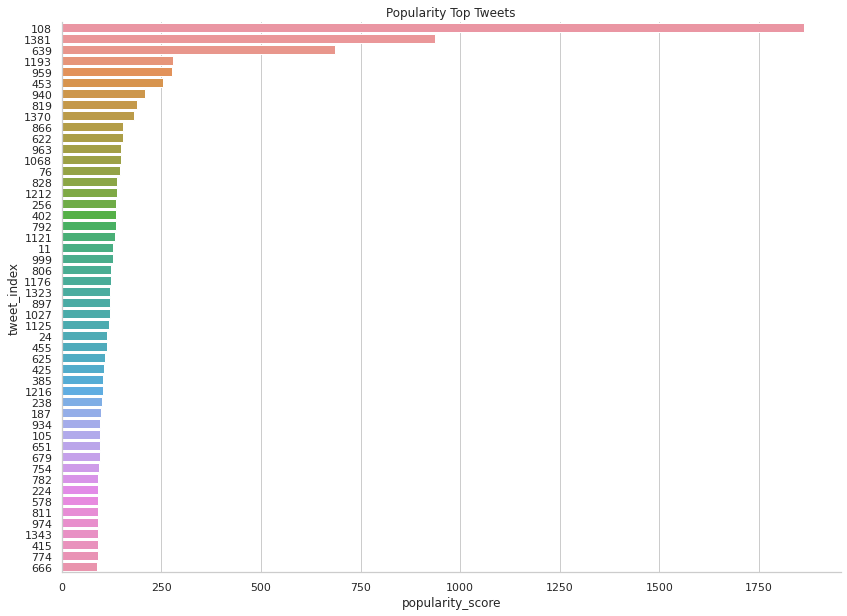

In [ ]:
index = top_tweets['tweet_index'].to_list()
top_tweets_plot = sns.catplot(y="tweet_index", x="popularity_score", orient="h", kind="bar", data=top_tweets, order=index, height=8.27, aspect=11.7/8.27).set(title='Popularity Top Tweets')


The graph shows that the first few tweets' popularity scores are very huge compared to the other tweets. There must be something in that tweet that makes it very popular.

### Breakdown of Popularity count
We want to see if the top tweet also has the highest favorite, retweet, quote tweet, and reply count so we plot the top tweets for each interaction. 

#### Based on Favorite Count
We first took the top 50 tweets based on the favorite count.

In [ ]:
top_tweets_favorite = data.nlargest(50, 'favorite_count').reset_index(drop=True)
top_tweets_favorite[['tweet_index', 'full_text', 'favorite_count']]

,tweet_index,full_text,favorite_count
0,108,DOH PRESS RELEASE\nPR No: 2021-01-13-01\n13 Ja...,1068
1,1381,"Ngayong 4 PM, Abril 2, 2021, ang Department of...",316
2,639,"Ngayong 4 PM, Abril 1, 2021, ang Department of...",119
3,959,"Ngayong 4 PM, Marso 29, 2021, ang Department o...",111
4,76,"""When other brands of vaccine with 'higher eff...",101
5,963,ALAMIN ANG TAMANG IMPORMASYON NGAYON ECQ!\n\nO...,87
6,1027,"UP-PGH Director Dr. Gerardo Legaspi, UP-Nation...",86
7,866,DOH ANNOUNCEMENT | Clarification on the allege...,84
8,11,"Ngayong 4 PM, Marso 31, 2021, ang Department o...",81
9,940,"Ngayong 4 PM, Abril 3, 2021, ang Department of...",77


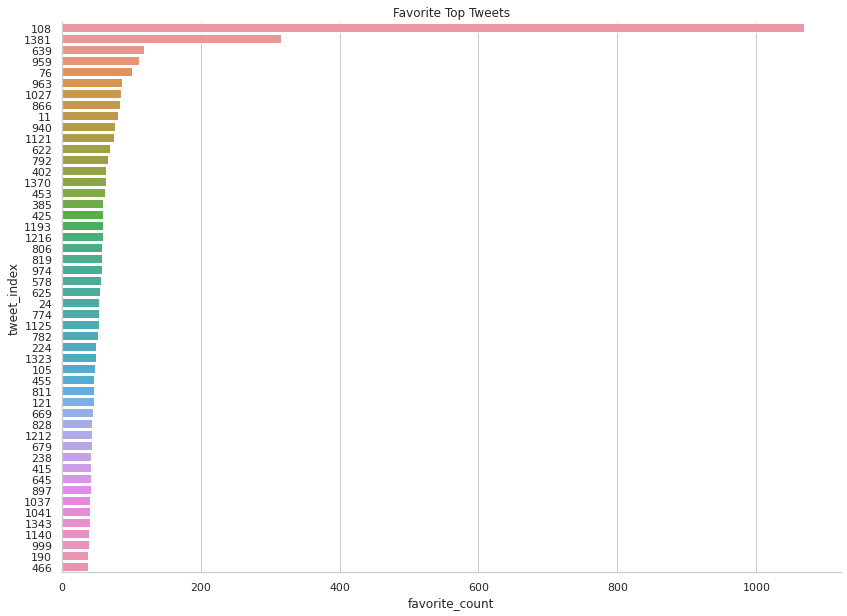

In [ ]:
index = top_tweets_favorite['tweet_index'].to_list()
top_tweets_favorite_plot = sns.catplot(y="tweet_index", x="favorite_count", orient="h", kind="bar", data=top_tweets_favorite, order=index, height=8.27, aspect=11.7/8.27).set(title='Favorite Top Tweets')

The top tweet on favorite is also the top tweet on the favorite count. It is also ahead by an overwhelming amount compared to the other tweets. Furthermore, the top 3 tweets remain in the same position. 

#### Based on Retweet Count
Next, we want to see if it is still the same with the retweet count.



In [ ]:
top_tweets_retweet = data.nlargest(50, 'retweet_count').reset_index(drop=True)
top_tweets_retweet[['tweet_index', 'full_text', 'retweet_count']]

,tweet_index,full_text,retweet_count
0,108,DOH PRESS RELEASE\nPR No: 2021-01-13-01\n13 Ja...,740
1,1381,"Ngayong 4 PM, Abril 2, 2021, ang Department of...",249
2,959,"Ngayong 4 PM, Marso 29, 2021, ang Department o...",89
3,622,Do you have comorbidities? Check out this info...,72
4,940,"Ngayong 4 PM, Abril 3, 2021, ang Department of...",68
5,639,"Ngayong 4 PM, Abril 1, 2021, ang Department of...",65
6,1193,"Ngayong 4 PM, Marso 19, 2021, ang Department o...",59
7,11,"Ngayong 4 PM, Marso 31, 2021, ang Department o...",49
8,866,DOH ANNOUNCEMENT | Clarification on the allege...,49
9,1370,"Ngayong 4 PM, Abril 9, 2021, ang Department of...",49


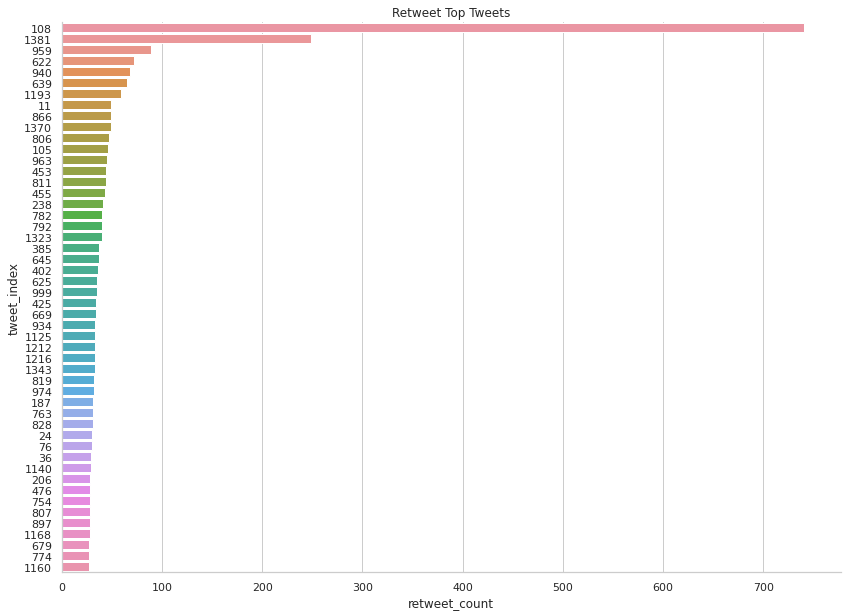

In [ ]:
index = top_tweets_retweet['tweet_index'].to_list()
top_tweets_retweet_plot = sns.catplot(y="tweet_index", x="retweet_count", orient="h", kind="bar", data=top_tweets_retweet, order=index, height=8.27, aspect=11.7/8.27).set(title='Retweet Top Tweets')

Similar to the favorite, the top tweet is the same as the one on the popularity score. It is also ahead by an overwhelming amount. The top 2nd tweet is also the same as the popularity score top.

#### Based on Quote Count

In [ ]:
top_tweets_quote = data.nlargest(50, 'quote_count').reset_index(drop=True)
top_tweets_quote[['tweet_index', 'full_text', 'quote_count']]

,tweet_index,full_text,quote_count
0,639,"Ngayong 4 PM, Abril 1, 2021, ang Department of...",486
1,1381,"Ngayong 4 PM, Abril 2, 2021, ang Department of...",338
2,1193,"Ngayong 4 PM, Marso 19, 2021, ang Department o...",152
3,453,"Ngayong 4 PM, Marso 25, 2021, ang Department o...",133
4,819,"Ngayong 4 PM, Marso 20, 2021, ang Department o...",78
5,1068,LOOK: The Department of Health garnered the 2n...,74
6,1176,"Ngayong 4 PM, Marso 26, 2021, ang Department o...",66
7,959,"Ngayong 4 PM, Marso 29, 2021, ang Department o...",63
8,940,"Ngayong 4 PM, Abril 3, 2021, ang Department of...",54
9,1370,"Ngayong 4 PM, Abril 9, 2021, ang Department of...",54


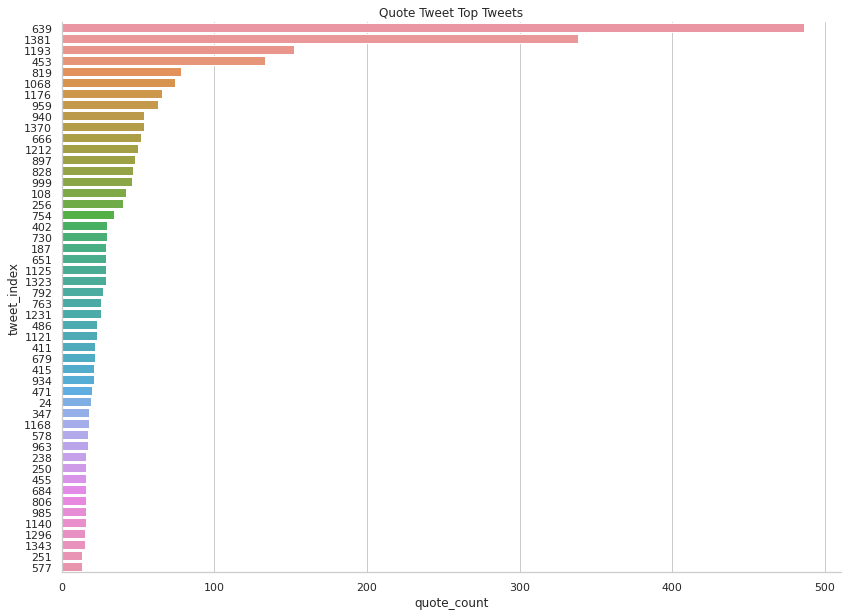

In [ ]:
index = top_tweets_quote['tweet_index'].to_list()
top_tweets_quote_plot = sns.catplot(y="tweet_index", x="quote_count", orient="h", kind="bar", data=top_tweets_quote, order=index, height=8.27, aspect=11.7/8.27).set(title='Quote Tweet Top Tweets')

The top 50 tweets based on the quote graph shows a different top tweet that ranked first. Looking for it, we found it at the top 15th place. This may be because the popularity score top 1st has an overwhelming amount of favorites and retweets, even though it had little quote tweet count, it still was able to stay on top. Additionally, the average number of quote tweets to the top 50 is smaller than the average number of the favorite tweets. This is why the favorite count plays a bigger role in the popularity of the tweet.


#### Based on Reply Count
We want to see if the top tweet also has the highest retweet count, which is why we plotted the top 50 tweets based on the number of retweet.

In [ ]:
top_tweets_reply = data.nlargest(50, 'reply_count').reset_index(drop=True)
top_tweets_reply[['tweet_index', 'full_text', 'reply_count']]

,tweet_index,full_text,reply_count
0,1068,LOOK: The Department of Health garnered the 2n...,61
1,256,Due to the increasing number of new cases of C...,46
2,1381,"Ngayong 4 PM, Abril 2, 2021, ang Department of...",34
3,819,"Ngayong 4 PM, Marso 20, 2021, ang Department o...",20
4,639,"Ngayong 4 PM, Abril 1, 2021, ang Department of...",17
5,666,I-download ang file na ito para malaman ang sa...,17
6,828,"Ngayong 4 PM, Marso 13, 2021, ang Department o...",16
7,42,Per FDA Advisory No. 2021-0526 issued on 15 Ma...,14
8,453,"Ngayong 4 PM, Marso 25, 2021, ang Department o...",14
9,1370,"Ngayong 4 PM, Abril 9, 2021, ang Department of...",14


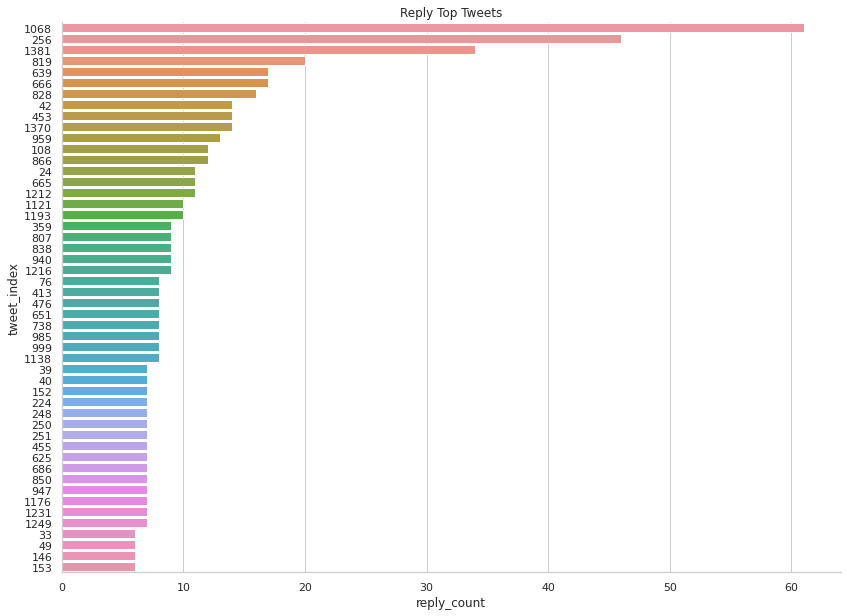

In [ ]:
index = top_tweets_reply['tweet_index'].to_list()
top_tweets_reply_plot = sns.catplot(y="tweet_index", x="reply_count", orient="h", kind="bar", data=top_tweets_reply, order=index, height=8.27, aspect=11.7/8.27).set(title='Reply Top Tweets')

The result shows that the tweet with the highest popularity count is not the one with the highest reply count, in fact, it is at number 11 in the number of replies. The average reply count amongst the top 50 tweets is significantly smaller than the other 3 interactions, this is why similar to the quote tweet, it plays a little role in the popularity of the tweet. 

#### Combination of the breakdowm of tweet popularity

In [ ]:
top_tweets_test = pd.melt(top_tweets[['tweet_index', 'full_text', 'popularity_score', 'favorite_count', 'retweet_count', 'quote_count','reply_count']], id_vars=["tweet_index", "full_text"], var_name="popularity", value_name="count")
top_tweets_test.head()

,tweet_index,full_text,popularity,count
0,108,DOH PRESS RELEASE\nPR No: 2021-01-13-01\n13 Ja...,popularity_score,1862
1,1381,"Ngayong 4 PM, Abril 2, 2021, ang Department of...",popularity_score,937
2,639,"Ngayong 4 PM, Abril 1, 2021, ang Department of...",popularity_score,687
3,1193,"Ngayong 4 PM, Marso 19, 2021, ang Department o...",popularity_score,280
4,959,"Ngayong 4 PM, Marso 29, 2021, ang Department o...",popularity_score,276


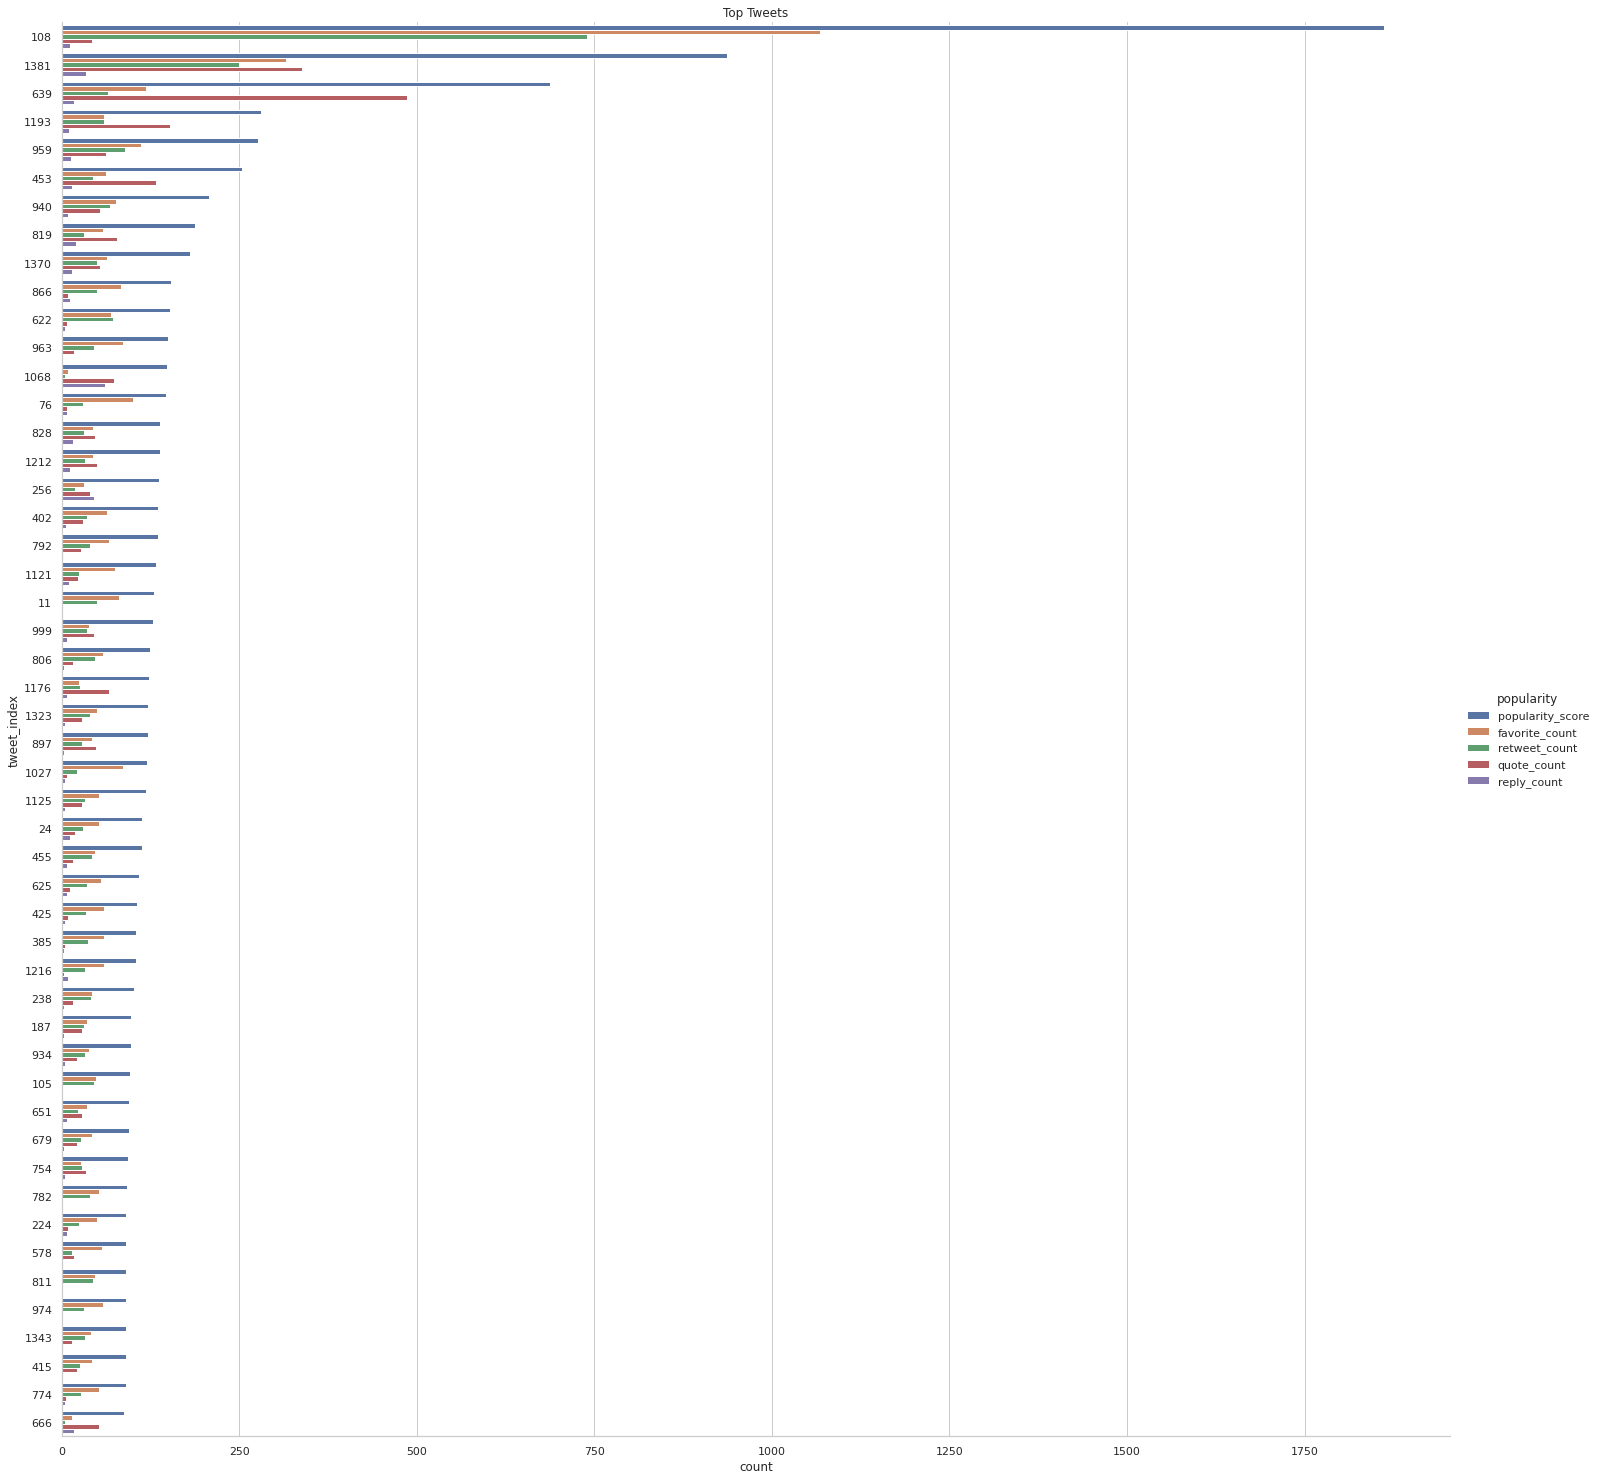

In [ ]:
top_tweet_breakdown = sns.catplot(y="tweet_index", 
                                         x="count", 
                                         orient="h", 
                                         kind="bar", 
                                         hue="popularity", 
                                        #  palette={"Customer": "g", "Subscriber": "m"}, 
                                         data=top_tweets_test,
                                         order=top_tweets['tweet_index'].values.tolist(),
                                         height=20.27).set(title='Top Tweets')

The graph shows how ahead is the top 1 tweet compared to the other tweets when it comes to the favorite and retweet count.

# 2. What are the characteristics of popular DOH tweets?

### Media Unary
With the different values of photos in media, we will be combining them into the variable photo. This will allow us to have two values of media which are media and video.

In [ ]:
def fixMedia(text):
  if not isinstance(text, float):
    # print(text)
    if "photo" in text:
      return "photo"
    else:
      return text
  else:
    return "None"

In [ ]:
data["media"] = data["media"].map(fixMedia)
top_tweets["media"] = top_tweets["media"].map(fixMedia)

After fixing, we started looking at the types of media attachments first by plotting the total tally of the media attachments categorized into either ‘none’ meaning no attachment, ‘photo’ if they contain photos, or ‘video’ if they contain videos.  

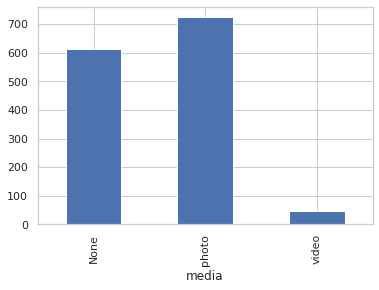

In [ ]:
data_media = data.groupby("media").size() 
data_media.plot.bar()

From here, we can see that the type of media attachments that are the most prevalent in the tweets are photos, which exceeded even tweets that have no attachments. In contrast, tweets with videos are much fewer.  

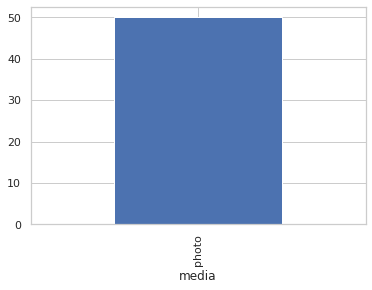

In [ ]:
data_top50_media = top_tweets.groupby("media").size() 
data_top50_media.plot.bar()

After plotting the type of media attachments the top 50 tweets by DOH use, it is interesting to see that none of the top 50 tweets have videos attached to them; only photos. Furthermore, all 50 tweets actually have photos attached to them. 

### Hashtag Unary

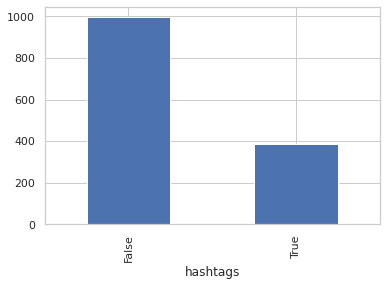

In [ ]:
data_hashtag = data.groupby("hashtags").size() 
data_hashtag.plot.bar()

The graph above shows us that most of DOH’s tweets are not using hashtags.

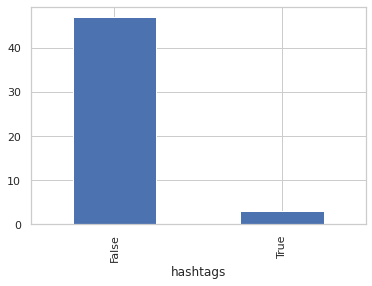

In [ ]:
data_top50_hashtag = top_tweets.groupby("hashtags").size() 
data_top50_hashtag.plot.bar()

When we plotted the use of hashtags for the top 50 tweets only, we saw that majority of the top 50 tweets did not make use of any hashtags. However, we believe that the disuse of hashtags was not the primary reason for the popularity of the tweet as only a handful of DOH tweets contained hashtags.




### Keyword Unary
We then want to see the keywords used by DOH in their tweets. This will give us an idea on what the topic of the tweet is and what they mostly talk about. 

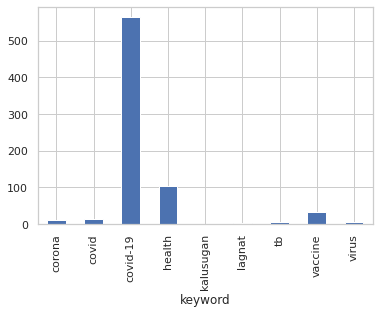

In [ ]:
data_keyword = data.groupby("keyword").size() 
data_keyword.plot.bar()

These keywords - ‘corona’, ‘covid’, ‘covid-19’, ‘health’, ‘kalusugan’, ‘lagnat’, ‘tb’, ‘vaccine’, and ‘virus’ - were the ones that were used by DOH from our list of health-related keywords. But among these keywords, ‘covid-19’ was the most prevalent, followed by ‘health’, then ‘vaccine’. From here, we can see the impact of the ongoing pandemic on the content of the tweets posted by DOH for the past year. 

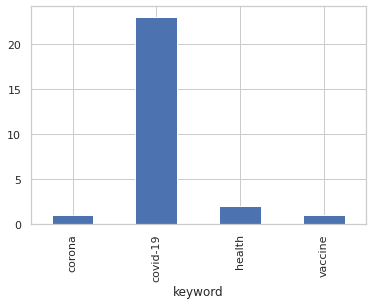

In [ ]:
data_top50_keyword = top_tweets.groupby("keyword").size() 
data_top50_keyword.plot.bar()

We then plotted the keywords of the top 50 tweets, this time resulting in ‘covid-19’ once again the most prevalent, followed by ‘health’, then ‘corona’ and ‘vaccine’ in a tie. This simply cements the main themes that DOH primarily tweets about as well as, from the interactions of the public, where the interest of the target audience lies, which is the virus. 


### Possibly Sensitive Unary

We also took note of whether the tweets might contain sensitive languages such as profanities or slurs. 


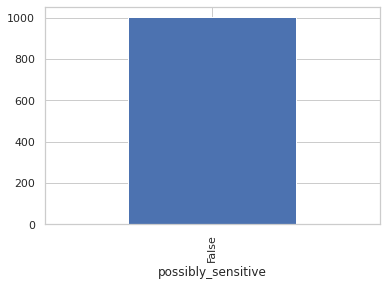

In [ ]:
data_ps = data.groupby("possibly_sensitive").size() 
data_ps.plot.bar()

As expected from a government organization, all tweets by DOH do not contain languages deemed sensitive by Twitter. Since all of the DOH's tweets do not contain sensitive words, there is no need to plot the top 50 tweets.

### Language Unary
We then plotted the lang attribute of the tweets of DOH to see what are the common language they are using to communicate with the public. 


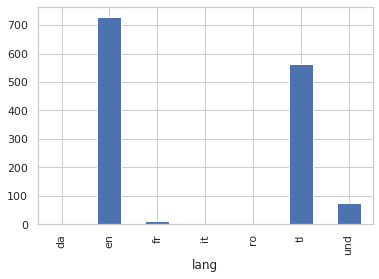

In [ ]:
data_lang = data.groupby("lang").size() 
data_lang.plot.bar()

It is surprising to see that there are other languages, such as Danish, French. Italian, and Roman, tagged to the DOH tweets since DOH only communicates with local languages or English.

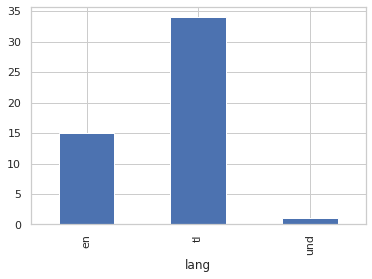

In [ ]:
data_top50_lang = top_tweets.groupby("lang").size() 
data_top50_lang.plot.bar()

Upon checking the top 50 tweets only, it shows that majority of the tweets are written in Tagalog. However, the previous graph just proved how inaccurate the language tagging of Twitter is since the tweets are not really written in those foreign languages. Moreover, Twitter is not able to identify Taglish tweets since it would only categorize them by either Tagalog or English. 


### Sentiment Unary
We then plot the sentiment of the DOH tweets. The sentiment is taken by spotting certain negative keywords, emojis, and emoticons and labeling is based on the absence or presence of those words, gathered from various sources (listed below). We plotted the sentiment of the tweets of all DOH tweets and the top 50 tweets only.

- (English Keywords) https://github.com/jeffreybreen/twitter-sentiment-analysis-tutorial-201107/blob/master/data/opinion-lexicon-English/negative-words.txt
- (Filipino Profanities) https://github.com/jromest/filipino-badwords-list/blob/master/src/filipino-badwords-list.js
- (Emoji) https://github.com/words/emoji-emotion
- (Emoticons)  https://link.springer.com/chapter/10.1007/978-3-319-18117-2_4
- others taken from Dr. Charibeth Cheng

Before identifying the sentiment of the tweet, the full_text of the tweet underwent preprocessing; such as handle removal and hyperlink removal. This is because handles and hyperlink might contain negative keyword, which we don't want to flag and it might cause inaccuracy in tagging the sentiment of the tweet.

In [ ]:
import csv
import re

with open('/content/drive/Shareddrives/FOURTUNATE/AY 2020-2021 Term 2/DATASCI/DATASCI Final Project/Final Project Files/final_negative_keywords.csv', newline='') as f:
    reader = csv.reader(f)
    temp = list(reader)
negative_keywords = [re.sub(r"[^A-Za-z0-9]", "", x[0].lower().strip()) for x in temp if x[0] != '']

with open('/content/drive/Shareddrives/FOURTUNATE/AY 2020-2021 Term 2/DATASCI/DATASCI Final Project/Final Project Files/negative_emo.csv', newline='') as f:
    reader = csv.reader(f)
    temp = list(reader)
negative_emo = [x[0].strip() for x in temp if x[0] != '']

def clean_text(full_tweet):
  full_tweet = re.sub(r"@\S+", "", full_tweet).strip()
  full_tweet = re.sub(r"https\S+", "", full_tweet).strip()
  return full_tweet.lower()

def getSenti(full_tweet):
  full_tweet = clean_text(full_tweet)
  for i in negative_emo:
    if i in full_tweet:
      return 'negative'
  tweet_words = full_tweet.split(' ')
  for i in negative_keywords:
    if ' ' in i and i in full_tweet:
      return 'negative'
    elif ' ' not in i and i in tweet_words:
      return 'negative'
  hashtags = re.findall(r"#[A-Za-z0-9]*", full_tweet)
  for i in hashtags:
    for j in negative_keywords:
      if ' ' in j and re.sub(r"[ ]", "", j) in i:
        return 'negative'
      elif ' ' not in j and j in i:
        return 'negative'
  return 'positive'

In [ ]:
data['sentiment'] = data.apply(lambda x : getSenti(x['full_text']), axis=1)
top_tweets['sentiment'] = top_tweets.apply(lambda x : getSenti(x['full_text']), axis=1)

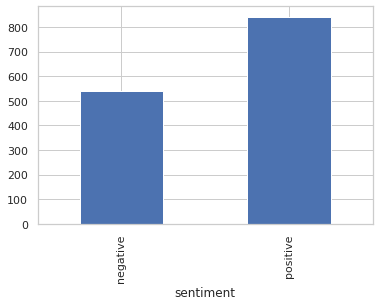

In [ ]:
data_senti = data.groupby("sentiment").size() 
data_senti.plot.bar()

The majority of the DOH tweets are positive, which is to be expected since they are one of the biggest health organizations in the Philippines. We expected them to be positive in these trying times. 

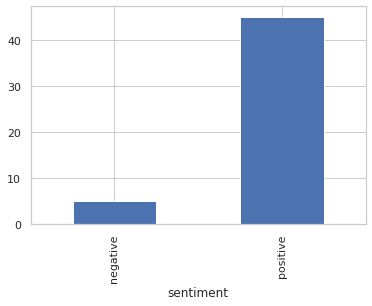

In [ ]:
data_top50_senti = top_tweets.groupby("sentiment").size() 
data_top50_senti.plot.bar()

In the graph of the top 50, the difference between the negative and positive sentiments is bigger. It might be that people like positive tweets more, thus share/interact with them more.


### Combination of the breakdown of the top characteristics of the most popular tweets


#### Based on Hashtags vs Interaction

We wanted to see how the presence of hashtags could have affected the retweet, favorite, reply, and quote tweet count of the most popular tweets.

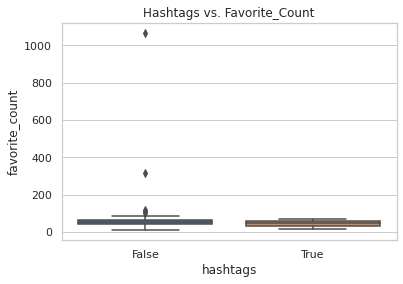

In [ ]:
sns.set_theme(style="whitegrid")
top_hashtags = sns.boxplot(x=top_tweets["hashtags"], y=top_tweets["favorite_count"]).set(title='Hashtags vs. Favorite_Count')

The graph of Hashtag vs favorite count shows that the tweets with hashtags are normally perceived similarly since the average and the range of values are similar.

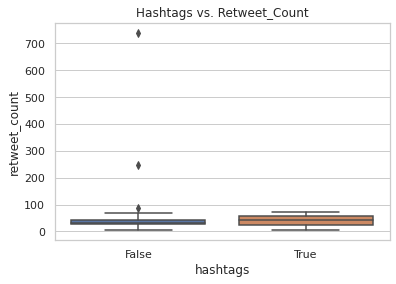

In [ ]:
sns.set_theme(style="whitegrid")
top_hashtags = sns.boxplot(x=top_tweets["hashtags"], y=top_tweets["retweet_count"]).set(title='Hashtags vs. Retweet_Count')

Looking at the graph, we can see that for the most part, both the presence and lack of hashtags give the same retweet count range, with the exception for the outliers found with tweets that do not have hashtags. This means that generally, the presence of hashtags do not affect its retweet count.


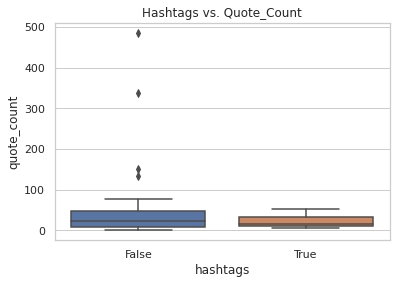

In [ ]:
sns.set_theme(style="whitegrid")
top_hashtags = sns.boxplot(x=top_tweets["hashtags"], y=top_tweets["quote_count"]).set(title='Hashtags vs. Quote_Count')

Similarly, results with the retweet count and favorite count are seen with the quote tweet count. The average of both with and without hashtags is almost the same but the one with the hashtag is slightly lower and the range of values is also on the lower value compared to the one without the hashtag.

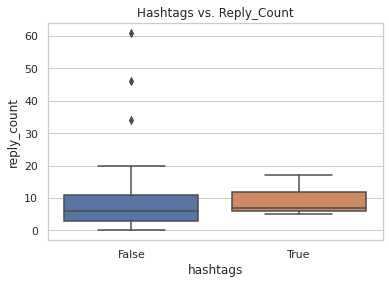

In [ ]:
sns.set_theme(style="whitegrid")
top_hashtags = sns.boxplot(x=top_tweets["hashtags"], y=top_tweets["reply_count"]).set(title='Hashtags vs. Reply_Count')

Looking at the graph, we can see that for the most part, both the presence and lack of hashtags give the same retweet count range, with the exception for the outliers found with tweets that do not have hashtags. This means that generally, the presence of hashtags do not affect its retweet count.


#### Based on Sentiment vs Interaction

We then compared the sentiment of the tweet to the number of each interaction on the top 50 tweets. To see if the sentiment has a significance in the number of interaction made in the tweet.

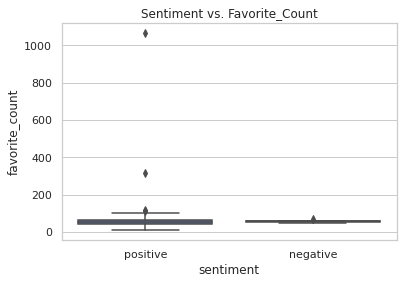

In [ ]:
sns.set_theme(style="whitegrid")
top_sentiment = sns.boxplot(x=top_tweets["sentiment"], y=top_tweets["favorite_count"]).set(title='Sentiment vs. Favorite_Count')

When plotting the sentiment to favorite count, the average of positive sentiment is a little bit smaller compared to the negative sentiment. The range of values in the negative sentiment is also smaller. However, when looking at the outliers, it belongs to the positive sentiment. This means that the most popular tweet is a positive sentiment.


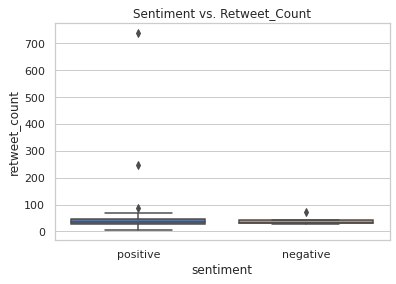

In [ ]:
sns.set_theme(style="whitegrid")
top_sentiment = sns.boxplot(x=top_tweets["sentiment"], y=top_tweets["retweet_count"]).set(title='Sentiment vs. Retweet_Count')

After plotting the retweet count in a boxplot. It can be seen that the average retweet of the top 50 tweets is almost similar to each other. This means that the sentiment of the tweet generally receives the same amount of retweet count. However, it can be seen that the highest number of retweets still belongs to the positive sentiment, this means that positive tweets are still perceived better by the public.


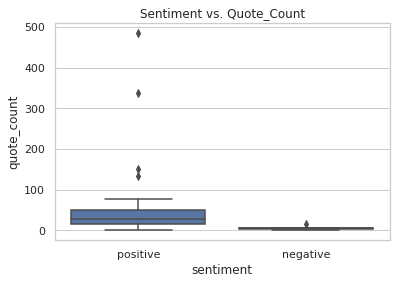

In [ ]:
sns.set_theme(style="whitegrid")
top_sentiment = sns.boxplot(x=top_tweets["sentiment"], y=top_tweets["quote_count"]).set(title='Sentiment vs. Quote_Count')

After plotting the quote tweet count with respect to the sentiment of the tweet, the average of positive sentiment is significantly higher than that of negative sentiment, and that the highest quote tweet count also belongs to positive tweets, which shows how people tend to quote positive tweets more frequently.

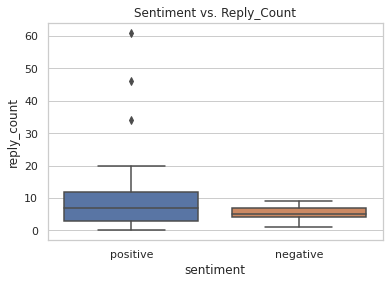

In [ ]:
sns.set_theme(style="whitegrid")
top_sentiment = sns.boxplot(x=top_tweets["sentiment"], y=top_tweets["reply_count"]).set(title='Sentiment vs. Reply_Count')

We then plotted the reply count with respect to the sentiment of the tweet. The graph shows that the average of the positive sentiment is higher than the negative, which may mean that people reply more to positive tweets of DOH. Moreover, the highest reply also belongs to the positive sentiment.


#### Comparison of Hashtag and Sentiment to retweet + favorite count and quote + reply count

In this section, we will be comparing hashtag and sentiment to the retweet + favorite count and quote + reply count values

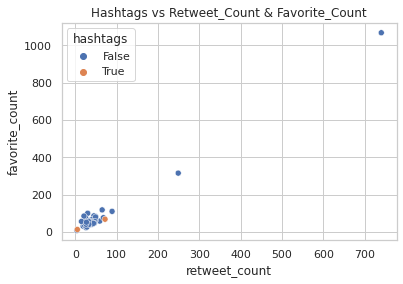

In [ ]:
top_hashtags = sns.scatterplot(data=top_tweets, x="retweet_count", y="favorite_count", hue="hashtags").set(title="Hashtags vs Retweet_Count & Favorite_Count")

We compared the use of hashtags to the number of favorite and retweet counts. The majority of the tweets are on the lower portion of the graph. It can also be seen that there seems to be a relationship between the number of favorites and retweets. Ignoring the outliers, the tweets with hashtags seem to be both in the higher and lower bound of the number of favorite and retweet. This means that the hashtag is not really significant in the number of favorite and retweet.

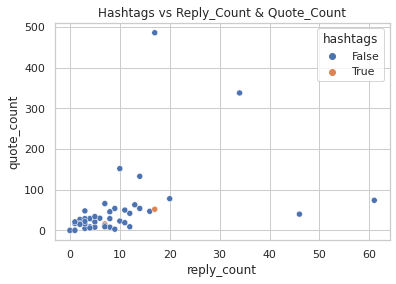

In [ ]:
top_hashtags = sns.scatterplot(data=top_tweets, x="reply_count", y="quote_count", hue="hashtags").set(title="Hashtags vs Reply_Count & Quote_Count")

Similarly, we did the same with reply and quote tweets. The dots seem more erratic in this graph and there are many outliers. However, there also seems to be a trend in the number of quote tweet and reply count, albeit it being smaller. The tweets where there is a hashtag are in the middle of the range, ignoring the outliers. Similar to the results in hashtag vs reply, the one with hashtags is in the upper range of the reply count.


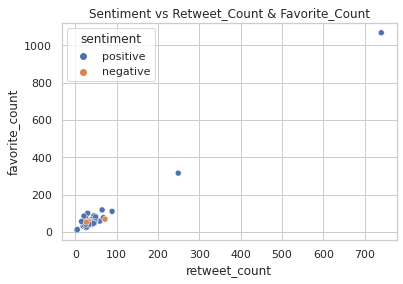

In [ ]:
top_senti = sns.scatterplot(data=top_tweets, x="retweet_count", y="favorite_count", hue="sentiment").set(title="Sentiment vs Retweet_Count & Favorite_Count")

We did the same with the sentiment and comparing the positive and negative sentiment, it can be seen that they are in around the same area. This means that the sentiment does not really affect the number of the favorite and retweet.

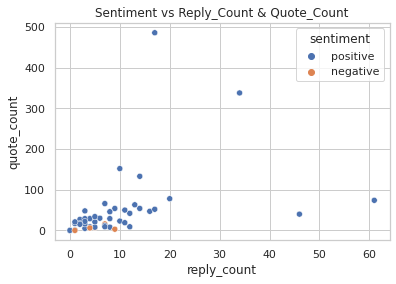

In [ ]:
top_senti = sns.scatterplot(data=top_tweets, x="reply_count", y="quote_count", hue="sentiment").set(title="Sentiment vs Reply_Count & Quote_Count")

For the reply and the quote tweet, it can be seen that the quote count of the negative sentiment is in the lower bound of the values, this may mean that negative sentiment is rarely quoted by the public. When it comes to the reply count, it seems that the negative sentiment is well distributed to the average area.


#### Sentiment & Hashtag vs Interaction

Using the df.apply function, we will be creating a new column called 'media and hashtags'. This will allow us to visualize the correlation between media and hashtags to retweet count and favorite count.

We then plotted the sentiment-hashtag pairing to see which combination is the top tweets are composed of. When we plotted the sentiment-hashtag. We found out that the top tweets are majorly composed of positive sentiment and with a hashtag.

We now turn to examining the relationship between the amount of interactions versus tweets with sentiment and hashtags characteristics.


In [ ]:
top_tweets['sentiment and hashtag'] = top_tweets.apply(lambda x : x['sentiment'] + ' sentiment ' + (' with ' if x['hashtags'] is True else ' without ') + 'hashtag', axis=1)

[Text(0.5, 1.0, 'Favorite_Count vs Sentiment & Hashtag')]

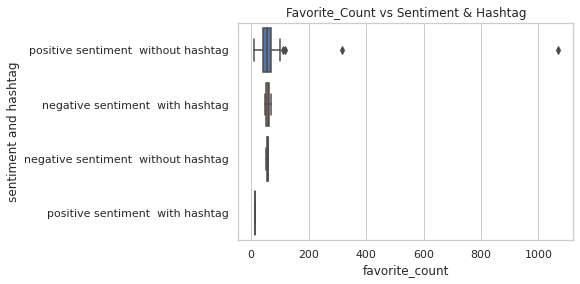

In [ ]:
sns.set_theme(style="whitegrid")
sns.boxplot(y=top_tweets["sentiment and hashtag"], x = top_tweets["favorite_count"]).set(title="Favorite_Count vs Sentiment & Hashtag")

Here, we have compared the favorite count to DOH’s tweets categorised with sentiment and hashtags. As the medians of the positive sentiment without hashtags, negative sentiment with hashtags, and negative sentiment without hashtags are approximately the same, this indicates that the presence of hashtags does not seem to affect the tendency of users to favorite the tweets. We should also note, however, that the outliers with the highest amount of favorites belong to tweets with positive sentiment and without hashtags, with these tweets also having the highest variability in terms of favorite count. As for tweets with positive sentiment and hashtags, the count is quite a few compared to the others; however, the upper and lower bound seem to be the same as the average, so it might be just one tweet.


[Text(0.5, 1.0, 'Retweet_Count vs Sentiment & Hashtag')]

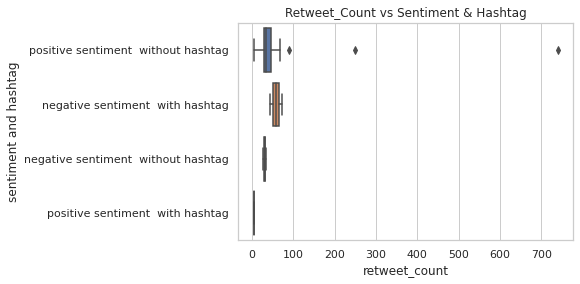

In [ ]:
sns.set_theme(style="whitegrid")
sns.boxplot(y=top_tweets["sentiment and hashtag"], x = top_tweets["retweet_count"]).set(title="Retweet_Count vs Sentiment & Hashtag")

In comparing the retweet count, we notice that the median of the tweets with negative sentiment and hashtags is the highest, which indicates that people might tend to retweet these types of tweets more frequently. The upper and lower bounds are also the highest, which supports the hypothesis. However, it should be noted that, as seen in the comparison to the favorite count, the ones with the outliers still belong to the tweets with positive sentiment and without hashtags. 


[Text(0.5, 1.0, 'Quote_Count vs Sentiment & Hashtag')]

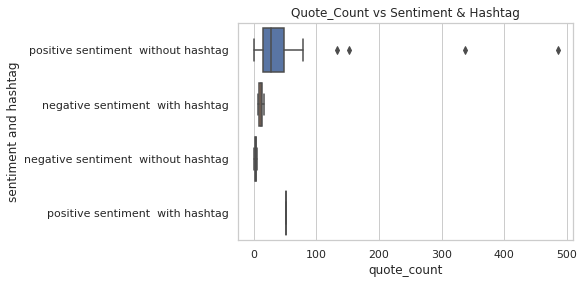

In [ ]:
sns.set_theme(style="whitegrid")
sns.boxplot(y=top_tweets["sentiment and hashtag"], x = top_tweets["quote_count"]).set(title="Quote_Count vs Sentiment & Hashtag")

When we graph the pair with the quote count, it can be seen that the range of the positive sentiment with hashtags is bigger compared to other combinations. It can be said that negative sentiment without hashtags receives the lowest quote count, so it tends to not be quoted much. Similarly, although it has a higher average compared to negative sentiment without hashtags, the negative sentiment with hashtags also has a low quote count, so it is generally quoted less compared to the positive sentiment with hashtags. Since positive sentiment without hashtags seems to be just one tweet, not much can be said about it.


[Text(0.5, 1.0, 'Reply_Count vs Sentiment & Hashtag')]

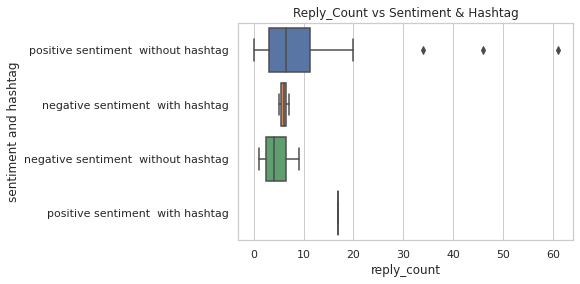

In [ ]:
sns.set_theme(style="whitegrid")
sns.boxplot(y=top_tweets["sentiment and hashtag"], x = top_tweets["reply_count"]).set(title="Reply_Count vs Sentiment & Hashtag")

When we plotted the sentiment-hashtag vs the reply count. We found out that the ones with the highest average are the positive sentiment with hashtag. Next to it is the positive sentiment without hashtags; however, it also possesses the one with the lowest lower bound, so it can be said that the reply count of this category is well distributed. The next one is the negative sentiment with hashtags, and finally the negative sentiment without hashtags. However, it can be seen that the negative sentiment without hashtags is more distributed. With this graph, it can be concluded that the sentiment-hashtag does not necessarily affect the reply count.



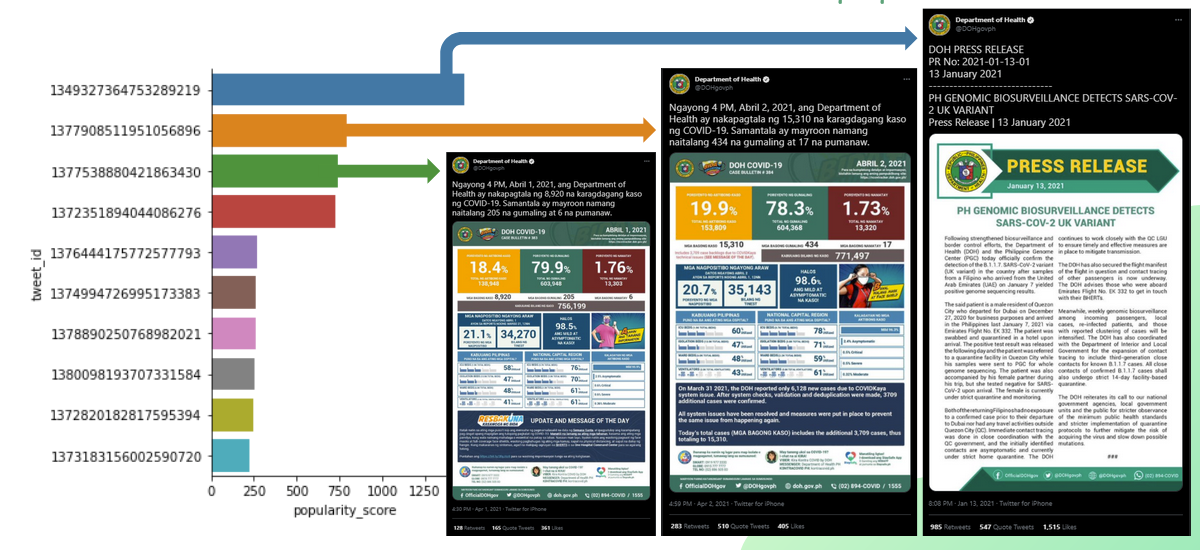

We took a look at the top 3 tweets on Twitter and, as seen in the visualization above, all top 3 indeed have photos attached to them — two of which are info-graphics showing the statistics about COVID-19 as of the date of the tweet. There are also no hashtags to be seen.

# 3. Do the tweets of DOH gain more traction compared to that of other influential users (Dr. Tony, WHOph)?

In [ ]:
data_who = pd.read_csv('/content/drive/Shareddrives/FOURTUNATE/AY 2020-2021 Term 2/DATASCI/DATASCI Final Project/Final Project Files/Dataset/WHOph_tweets.csv')
# data_who.head()

In [ ]:
data_who_reply = pd.read_csv('/content/drive/Shareddrives/FOURTUNATE/AY 2020-2021 Term 2/DATASCI/DATASCI Final Project/Final Project Files/Dataset/WHOph_reply.csv')
data_who_quote = pd.read_csv('/content/drive/Shareddrives/FOURTUNATE/AY 2020-2021 Term 2/DATASCI/DATASCI Final Project/Final Project Files/Dataset/WHOph_quotetweet.csv')

In [ ]:
data_drTony = pd.read_csv('/content/drive/Shareddrives/FOURTUNATE/AY 2020-2021 Term 2/DATASCI/DATASCI Final Project/Final Project Files/Dataset/Dr_tony_tweets.csv')
# data_drTony.head()

In [ ]:
data_drTony_reply = pd.read_csv('/content/drive/Shareddrives/FOURTUNATE/AY 2020-2021 Term 2/DATASCI/DATASCI Final Project/Final Project Files/Dataset/Dr_tony_reply.csv')
data_drTony_quote = pd.read_csv('/content/drive/Shareddrives/FOURTUNATE/AY 2020-2021 Term 2/DATASCI/DATASCI Final Project/Final Project Files/Dataset/Dr_tony_quotetweet.csv')


Similar to the DOH, we made a function that adds tallies the number of replies and quote tweet to be able to calculate the popularity score. This is done for both WHO and Dr. Tony.

In [ ]:
def get_user_reply_count(tweet_id, user):
  if (user=="WHO"):
    return len(data_who_reply[data_who_reply['in_reply_to_status_id_str'] == tweet_id])
  elif (user=="DrTony"):
    return len(data_drTony_reply[data_drTony_reply['in_reply_to_status_id_str'] == tweet_id])

def get_user_quote_count(tweet_id, user):
  if (user=="WHO"):
    return len(data_who_quote[data_who_quote['quoted_status_id_str'] == tweet_id])
  elif (user=="DrTony"):
    return len(data_drTony_quote[data_drTony_quote['quoted_status_id_str'] == tweet_id])

In [ ]:
data_who['reply_count'] = data_who.apply(lambda x: get_user_reply_count(x['tweet_id'], "WHO"), axis=1)
data_who['quote_count'] = data_who.apply(lambda x: get_user_quote_count(x['tweet_id'], "WHO"), axis=1)
data_who['popularity_score'] = data_who.apply(lambda x: x['retweet_count'] + x['favorite_count'] + x['reply_count'] + x['quote_count'], axis=1)
data_who[['full_text', 'retweet_count', 'favorite_count', 'reply_count', 'quote_count', 'popularity_score']].head()

,full_text,retweet_count,favorite_count,reply_count,quote_count,popularity_score
0,Respect the #quarantine. \n\nBe aware of #COVI...,15,23,0,0,38
1,Healing hands and a caring heart – our healthc...,26,39,0,1,66
2,"1,072 additional people with COVID-19 have rec...",0,1,0,0,1
3,Update from the Department of Health this 24 M...,2,7,1,2,12
4,@usaid_manila's Mission Director Hardy shares ...,0,1,0,0,1


In [ ]:
data_drTony['reply_count'] = data_drTony.apply(lambda x: get_user_reply_count(x['tweet_id'], "DrTony"), axis=1)
data_drTony['quote_count'] = data_drTony.apply(lambda x: get_user_quote_count(x['tweet_id'], "DrTony"), axis=1)
data_drTony['popularity_score'] = data_drTony.apply(lambda x: x['retweet_count'] + x['favorite_count'] + x['reply_count'] + x['quote_count'], axis=1)
data_drTony[['full_text', 'retweet_count', 'favorite_count', 'reply_count', 'quote_count', 'popularity_score']].head()

,full_text,retweet_count,favorite_count,reply_count,quote_count,popularity_score
0,"RT @iamkarendavila: Yes @erienelao , a few day...",24,0,0,0,24
1,Will the COVID vaccine prevent me from infecti...,1,1,1,0,3
2,It’s time to review vaccination plan on how to...,1,8,0,0,9
3,“It is important to remember that about 45 peo...,0,4,0,0,4
4,"she said, but because she was concerned that i...",0,1,0,0,1


In [ ]:
top_tweets_who = data_who.nlargest(50, 'popularity_score').reset_index(drop=True)
top_tweets_drTony = data_drTony.nlargest(50, 'popularity_score').reset_index(drop=True)

### Calculate popularity
We made a new dataframe that has DOH, WHO, and Dr. Tony as rows and different popularity score we want to compare so that it will be easier to graph the values.

In [ ]:
compare = pd.DataFrame()
compare['Name'] = ['DOH', 'WHO', 'DR_Tony']
compare['Total_popularity_score'] = [data['popularity_score'].sum() , data_who['popularity_score'].sum() , data_drTony['popularity_score'].sum()]
compare['Total_retweet_score'] = [data['retweet_count'].sum() , data_who['retweet_count'].sum() , data_drTony['retweet_count'].sum()]
compare['Total_favorite_score'] = [data['favorite_count'].sum() , data_who['favorite_count'].sum() , data_drTony['favorite_count'].sum()]
compare['Total_reply_score'] = [data['reply_count'].sum() , data_who['reply_count'].sum() , data_drTony['reply_count'].sum()]
compare['Total_quote_score'] = [data['quote_count'].sum() , data_who['quote_count'].sum() , data_drTony['quote_count'].sum()]

compare['Average_popularity_score'] = [data['popularity_score'].mean() , data_who['popularity_score'].mean() , data_drTony['popularity_score'].mean()]
compare['Average_retweet_score'] = [data['retweet_count'].mean() , data_who['retweet_count'].mean() , data_drTony['retweet_count'].mean()]
compare['Average_favorite_score'] = [data['favorite_count'].mean() , data_who['favorite_count'].mean() , data_drTony['favorite_count'].mean()]
compare['Average_reply_score'] = [data['reply_count'].mean() , data_who['reply_count'].mean() , data_drTony['reply_count'].mean()]
compare['Average_quote_score'] = [data['quote_count'].mean() , data_who['quote_count'].mean() , data_drTony['quote_count'].mean()]

compare['Total_top_popularity_score'] = [top_tweets['popularity_score'].sum() , top_tweets_who['popularity_score'].sum() , top_tweets_drTony['popularity_score'].sum()]
compare['Total_top_retweet_score'] = [top_tweets['retweet_count'].sum() , top_tweets_who['retweet_count'].sum() , top_tweets_drTony['retweet_count'].sum()]
compare['Total_top_favorite_score'] = [top_tweets['favorite_count'].sum() , top_tweets_who['favorite_count'].sum() , top_tweets_drTony['favorite_count'].sum()]
compare['Total_top_reply_score'] = [top_tweets['reply_count'].sum() , top_tweets_who['reply_count'].sum() , top_tweets_drTony['reply_count'].sum()]
compare['Total_top_quote_score'] = [top_tweets['quote_count'].sum() , top_tweets_who['quote_count'].sum() , top_tweets_drTony['quote_count'].sum()]

compare['Average_top_popularity_score'] = [top_tweets['popularity_score'].mean() , top_tweets_who['popularity_score'].mean() , top_tweets_drTony['popularity_score'].mean()]
compare['Average_top_retweet_score'] = [top_tweets['retweet_count'].mean() , top_tweets_who['retweet_count'].mean() , top_tweets_drTony['retweet_count'].mean()]
compare['Average_top_favorite_score'] = [top_tweets['favorite_count'].mean() , top_tweets_who['favorite_count'].mean() , top_tweets_drTony['favorite_count'].mean()]
compare['Average_top_reply_score'] = [top_tweets['reply_count'].mean() , top_tweets_who['reply_count'].mean() , top_tweets_drTony['reply_count'].mean()]
compare['Average_top_quote_score'] = [top_tweets['quote_count'].mean() , top_tweets_who['quote_count'].mean() , top_tweets_drTony['quote_count'].mean()]

compare

,Name,Total_popularity_score,Total_retweet_score,Total_favorite_score,Total_reply_score,Total_quote_score,Average_popularity_score,Average_retweet_score,Average_favorite_score,Average_reply_score,Average_quote_score,Total_top_popularity_score,Total_top_retweet_score,Total_top_favorite_score,Total_top_reply_score,Total_top_quote_score,Average_top_popularity_score,Average_top_retweet_score,Average_top_favorite_score,Average_top_reply_score,Average_top_quote_score
0,DOH,25484,7867,12195,2044,3378,18.439942,5.692475,8.824168,1.479016,2.444284,9571,2746,4057,458,2310,191.42,54.92,81.14,9.16,46.20
1,WHO,6864,2261,3936,334,333,13.225434,4.356455,7.583815,0.643545,0.641618,2528,831,1425,59,213,50.56,16.62,28.50,1.18,4.26
2,DR_Tony,12061,2045,9213,594,209,32.597297,5.527027,24.900000,1.605405,0.564865,6768,1120,5299,272,77,135.36,22.40,105.98,5.44,1.54


### Total Popularity of the Users

We want to compare the total number of popularity score, favorite, retweet, quote tweet, and reply per user to see how they are performing overall. We plotted the popularity score and interactions individually to have a more intsightful findings.

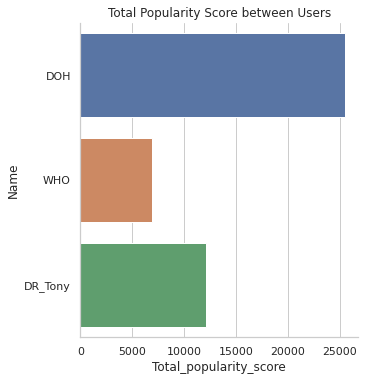

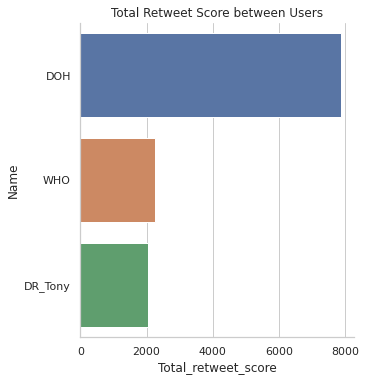

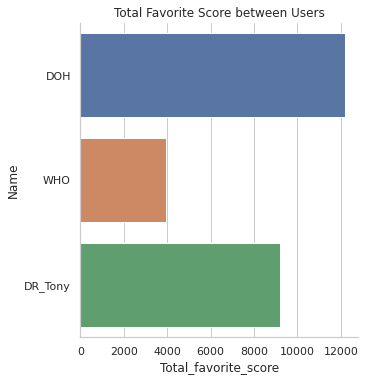

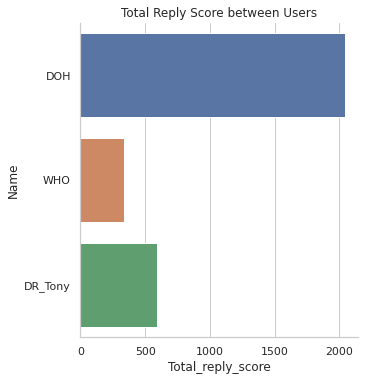

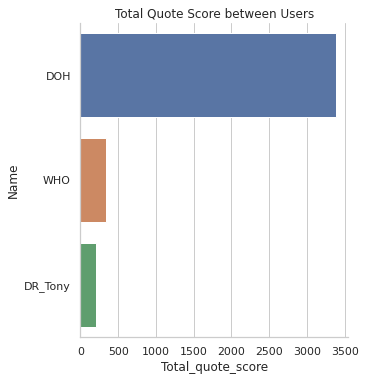

In [ ]:
index = compare['Name'].to_list()

sns.catplot(y="Name", x="Total_popularity_score", kind="bar", orient="h", data=compare, order=index).set(title='Total Popularity Score between Users')
sns.catplot(y="Name", x="Total_retweet_score", kind="bar", orient="h", data=compare, order=index).set(title='Total Retweet Score between Users')
sns.catplot(y="Name", x="Total_favorite_score", kind="bar", orient="h", data=compare, order=index).set(title='Total Favorite Score between Users')
sns.catplot(y="Name", x="Total_reply_score", kind="bar", orient="h", data=compare, order=index).set(title='Total Reply Score between Users')
sns.catplot(y="Name", x="Total_quote_score", kind="bar", orient="h", data=compare, order=index).set(title='Total Quote Score between Users')


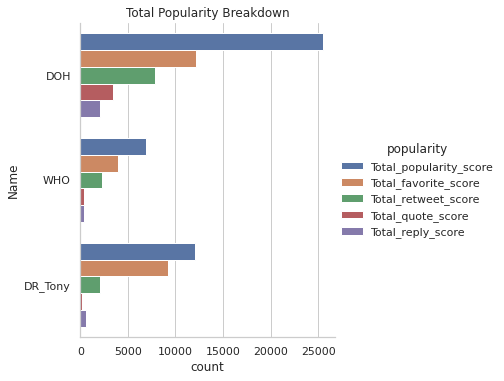

In [ ]:
compare_test = pd.melt(compare[['Name', 'Total_popularity_score', 'Total_favorite_score', 'Total_retweet_score', 'Total_quote_score', 'Total_reply_score']], id_vars=["Name"], var_name="popularity", value_name="count")
total_breakdown = sns.catplot(y="Name", 
                              x="count", 
                              orient="h", 
                              kind="bar", 
                              hue="popularity", 
                            #  palette={"Customer": "g", "Subscriber": "m"}, 
                              data=compare_test,
                              order=index).set(title='Total Popularity Breakdown')

The results shows that DOH dominated all categories, which might have been because of the overwhelming amoung of DOH tweets, with 1382. What's surprising is that the tweets of Dr.Tony seems to have a higher popularity compared to the WHO despite WHO having more tweets. 519 for WHO and 370 for Dr.Tony.

### Average Popularity of the users
Since DOH has a huge amount of tweet compared to the other 2 users, we decided to take the average interaction of the users.

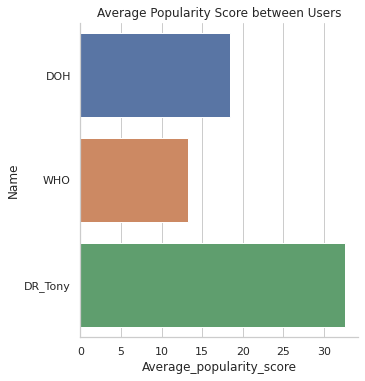

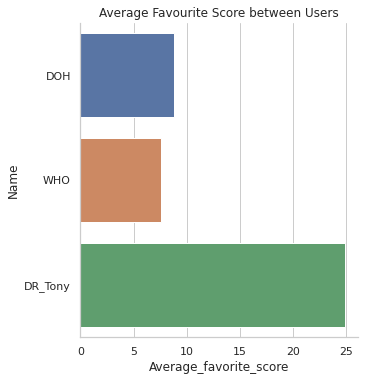

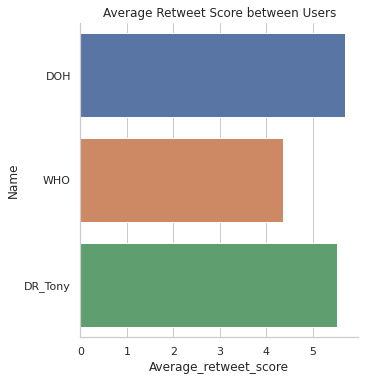

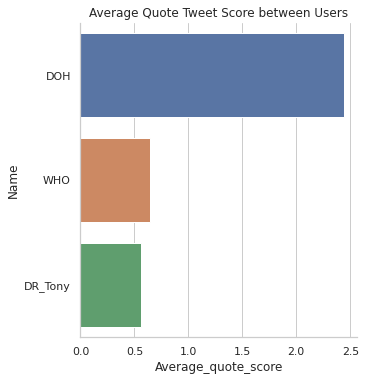

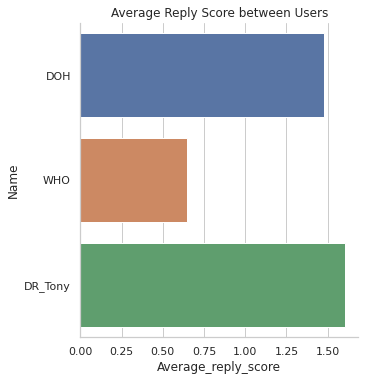

In [ ]:
compare_plot = sns.catplot(y="Name", x="Average_popularity_score", kind="bar", orient="h", data=compare, order=index).set(title='Average Popularity Score between Users')
compare_plot = sns.catplot(y="Name", x="Average_favorite_score", kind="bar", orient="h", data=compare, order=index).set(title='Average Favourite Score between Users')
compare_plot = sns.catplot(y="Name", x="Average_retweet_score", kind="bar", orient="h", data=compare, order=index).set(title='Average Retweet Score between Users')
compare_plot = sns.catplot(y="Name", x="Average_quote_score", kind="bar", orient="h", data=compare, order=index).set(title='Average Quote Tweet Score between Users')
compare_plot = sns.catplot(y="Name", x="Average_reply_score", kind="bar", orient="h", data=compare, order=index).set(title='Average Reply Score between Users')

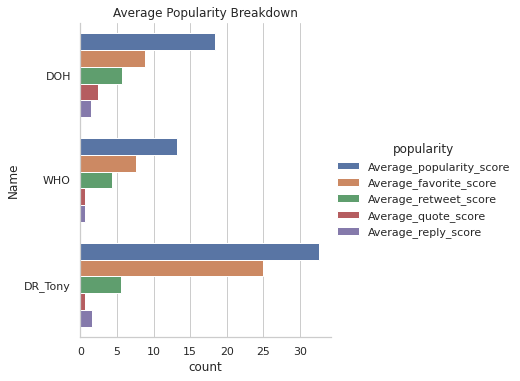

In [ ]:
compare_average_test = pd.melt(compare[['Name', 'Average_popularity_score', 'Average_favorite_score', 'Average_retweet_score', 'Average_quote_score', 'Average_reply_score']], id_vars=["Name"], var_name="popularity", value_name="count")
average_breakdown = sns.catplot(y="Name", 
                              x="count", 
                              orient="h", 
                              kind="bar", 
                              hue="popularity", 
                            #  palette={"Customer": "g", "Subscriber": "m"}, 
                              data=compare_average_test,
                              order=index).set(title='Average Popularity Breakdown')

The result shows that Dr.Tony has a higher average compared to DOH and WHO. DOH still remains above WHO's popularity. However, looking closely, we noticed that DOH has more retweet and quote count compared to Dr. Tony. Moreover, the reply count was not different by much. This shows that Dr.Tony's tweets are favorited by a lot. But not much by other counts.

### Total Popularity of the Top 50 tweets of the users
We want to further explore the popularity by taking only the top 50 tweets of each user. This is because getting the mean is not enough. This is because DOH might have a lot of no interacted tweets that causes the average popularity to go down. Taking the top 50 will give us a better insight of DOH's tweet.

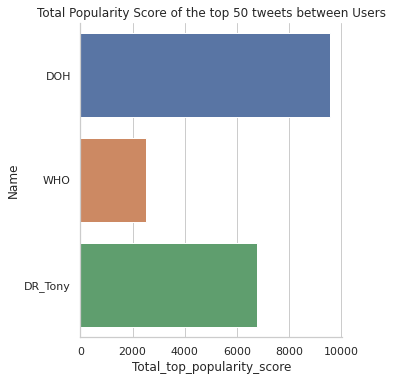

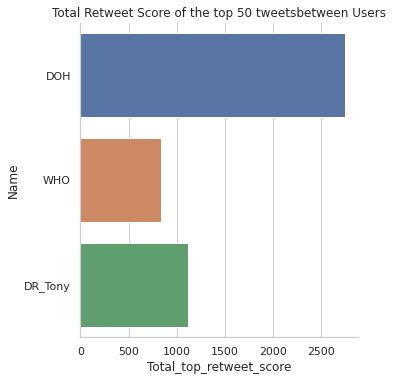

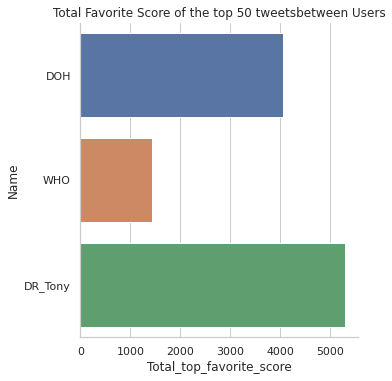

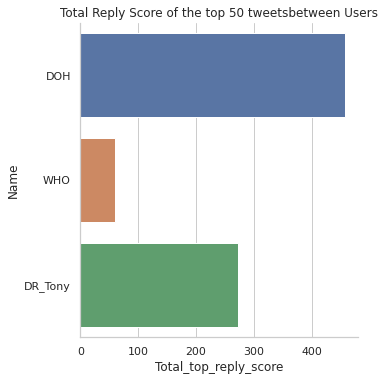

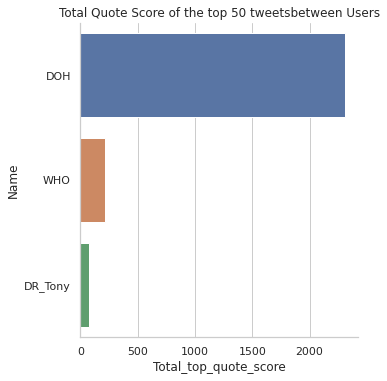

In [ ]:
sns.catplot(y="Name", x="Total_top_popularity_score", kind="bar", orient="h", data=compare, order=index).set(title='Total Popularity Score of the top 50 tweets between Users')
sns.catplot(y="Name", x="Total_top_retweet_score", kind="bar", orient="h", data=compare, order=index).set(title='Total Retweet Score of the top 50 tweetsbetween Users')
sns.catplot(y="Name", x="Total_top_favorite_score", kind="bar", orient="h", data=compare, order=index).set(title='Total Favorite Score of the top 50 tweetsbetween Users')
sns.catplot(y="Name", x="Total_top_reply_score", kind="bar", orient="h", data=compare, order=index).set(title='Total Reply Score of the top 50 tweetsbetween Users')
sns.catplot(y="Name", x="Total_top_quote_score", kind="bar", orient="h", data=compare, order=index).set(title='Total Quote Score of the top 50 tweetsbetween Users')


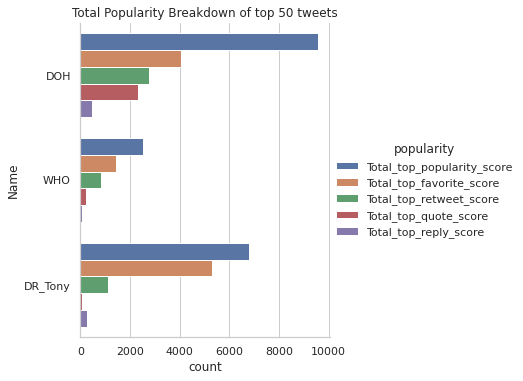

In [ ]:
compare_test = pd.melt(compare[['Name', 'Total_top_popularity_score', 'Total_top_favorite_score', 'Total_top_retweet_score', 'Total_top_quote_score', 'Total_top_reply_score']], id_vars=["Name"], var_name="popularity", value_name="count")
total_breakdown = sns.catplot(y="Name", 
                              x="count", 
                              orient="h", 
                              kind="bar", 
                              hue="popularity", 
                            #  palette={"Customer": "g", "Subscriber": "m"}, 
                              data=compare_test,
                              order=index).set(title='Total Popularity Breakdown of top 50 tweets')

The result of the top 50 tweets shows that DOH has a higher popularity comapred to the other users. Dr.Tony has only surpassed DOH's favorite count but DOH is higher with the rest of the interaction. This shows that Dr. Tony's tweets are frequently favorited compred to the other interaction, which makes it famous, but overall, DOH tweets are more popular.

### Average Popularity of the Top 50 tweets of the users
We also want to see the performance of the top 50 tweets when it comes to the average score.

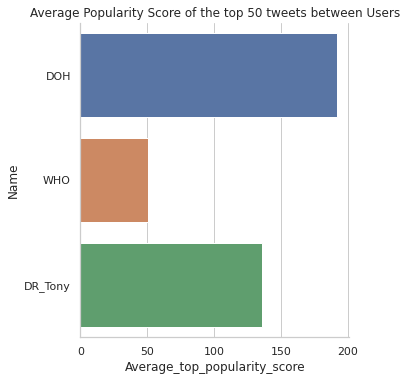

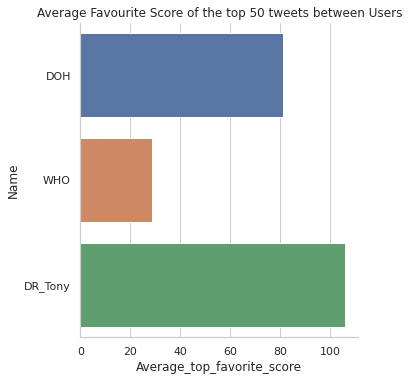

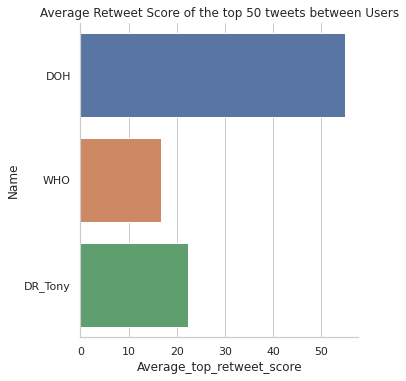

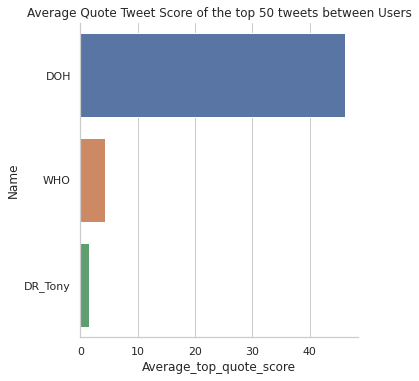

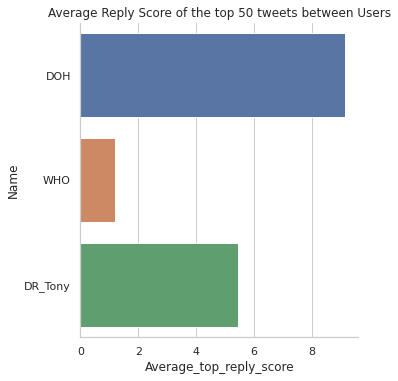

In [ ]:
compare_plot = sns.catplot(y="Name", x="Average_top_popularity_score", kind="bar", orient="h", data=compare, order=index).set(title='Average Popularity Score of the top 50 tweets between Users')
compare_plot = sns.catplot(y="Name", x="Average_top_favorite_score", kind="bar", orient="h", data=compare, order=index).set(title='Average Favourite Score of the top 50 tweets between Users')
compare_plot = sns.catplot(y="Name", x="Average_top_retweet_score", kind="bar", orient="h", data=compare, order=index).set(title='Average Retweet Score of the top 50 tweets between Users')
compare_plot = sns.catplot(y="Name", x="Average_top_quote_score", kind="bar", orient="h", data=compare, order=index).set(title='Average Quote Tweet Score of the top 50 tweets between Users')
compare_plot = sns.catplot(y="Name", x="Average_top_reply_score", kind="bar", orient="h", data=compare, order=index).set(title='Average Reply Score of the top 50 tweets between Users')

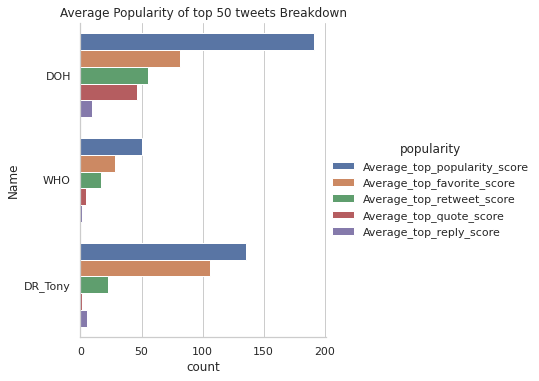

In [ ]:
compare_average_test = pd.melt(compare[['Name', 'Average_top_popularity_score', 'Average_top_favorite_score', 'Average_top_retweet_score', 'Average_top_quote_score', 'Average_top_reply_score']], id_vars=["Name"], var_name="popularity", value_name="count")
average_breakdown = sns.catplot(y="Name", 
                              x="count", 
                              orient="h", 
                              kind="bar", 
                              hue="popularity", 
                            #  palette={"Customer": "g", "Subscriber": "m"}, 
                              data=compare_average_test,
                              order=index).set(title='Average Popularity of top 50 tweets Breakdown')

The graph shows that DOH still has the higher popularity score compared to the two users. The values are not that different from the previous graph and the favorite of Dr. Tony is the only higher value compared to the DOH. 


**This tells us that DOH's tweets gain more traction compared to the other influencial users but it also has a lot of tweets that has little popularity.**

# 4. What are the sentiments of the replies and quoted tweets to the DOH tweets?


Because we want to know how people react to the tweets to DOH, we wanted to get the sentiment of the replies and quote tweets of the DOH tweets found in our dataset. We didn’t use the retweet of the DOH tweets since it is merely a copy of the original tweet with the addition of DOH’s screen name.

In [ ]:
data_reply['sentiment'] = data_reply.apply(lambda x : getSenti(x['full_text']), axis=1)
data_quote['sentiment'] = data_quote.apply(lambda x : getSenti(x['full_text']), axis=1)

### Comparing the Number of Positive and Negative Replies and Quote Tweets

In [ ]:
compare_senti = pd.DataFrame()
compare_senti['type'] = ['reply', 'reply', 'quote tweet', 'quote tweet', 'total', 'total']
compare_senti['sentiment'] = ['positive', 'negative','positive', 'negative','positive', 'negative']
compare_senti['count'] = [len(data_reply[data_reply['sentiment'] == 'positive']), len(data_reply[data_reply['sentiment'] == 'negative']), len(data_quote[data_quote['sentiment'] == 'positive']), len(data_quote[data_quote['sentiment'] == 'negative']), len(data_reply[data_reply['sentiment'] == 'positive']) + len(data_quote[data_quote['sentiment'] == 'positive']), len(data_reply[data_reply['sentiment'] == 'negative']) + len(data_quote[data_quote['sentiment'] == 'negative'])]
# compare_senti['negative_count'] = [len(data_reply[data_reply['sentiment'] == 'negative']) , len(data_quote[data_quote['sentiment'] == 'negative'])]

compare_senti

,type,sentiment,count
0,reply,positive,1478
1,reply,negative,722
2,quote tweet,positive,1963
3,quote tweet,negative,1576
4,total,positive,3441
5,total,negative,2298


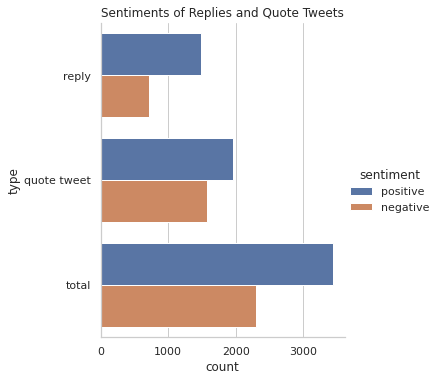

In [ ]:
compare_senti_breakdown = sns.catplot(y="type", 
                                         x="count", 
                                         orient="h", 
                                         kind="bar", 
                                         hue="sentiment", 
                                        #  palette={"Customer": "g", "Subscriber": "m"}, 
                                         data=compare_senti).set(title='Sentiments of Replies and Quote Tweets')
                                        #  order=top_tweets['tweet_id'].values.tolist()).set(title='Top Ten')

As seen above, we can see that the majority of the sentiments of the replies and quote tweets are positive. This is especially seen with replies, where the count of negative replies are very low compared to positive replies. However, with quoted tweets, the difference in count between negative and positive quoted tweets is much smaller. This could indicate that people express negative sentiments related to the original tweet more often through quoting the tweet rather than replying to the tweet.

### Comparing the Percentages of Replies and Quote Tweets with Positive, Negative, and Same Sentiment as the Original Tweet for the Most Popular Tweets

Next, we wanted to see the relationship between the sentiment of the original tweet and its replies and quote tweets, especially for the most popular tweets.

In [ ]:
def get_senti_reply_quote(tweet_id, sentiment):
    return 0 if (len(data_reply[data_reply['in_reply_to_status_id_str'] == tweet_id]) + len(data_quote[data_quote['quoted_status_id_str'] == tweet_id])) == 0 else ((len(data_reply[(data_reply['in_reply_to_status_id_str'] == tweet_id) & (data_reply['sentiment'] == sentiment)]) + len(data_quote[(data_quote['quoted_status_id_str'] == tweet_id) & (data_quote['sentiment'] == sentiment)])) / (len(data_reply[data_reply['in_reply_to_status_id_str'] == tweet_id]) + len(data_quote[data_quote['quoted_status_id_str'] == tweet_id])))

def get_senti_reply(tweet_id, sentiment):
    return 0 if len(data_reply[data_reply['in_reply_to_status_id_str'] == tweet_id]) == 0 else (len(data_reply[(data_reply['in_reply_to_status_id_str'] == tweet_id) & (data_reply['sentiment'] == sentiment)]) / len(data_reply[data_reply['in_reply_to_status_id_str'] == tweet_id]))

def get_senti_quote(tweet_id, sentiment):
    return 0 if len(data_quote[data_quote['quoted_status_id_str'] == tweet_id]) == 0 else (len(data_quote[(data_quote['quoted_status_id_str'] == tweet_id) & (data_quote['sentiment'] == sentiment)]) / len(data_quote[data_quote['quoted_status_id_str'] == tweet_id]))

In [ ]:
top_tweets['same sentiment'] = top_tweets.apply(lambda x : get_senti_reply_quote(x['tweet_id'], x['sentiment']), axis = 1)
top_tweets['same sentiment-reply'] = top_tweets.apply(lambda x : get_senti_reply(x['tweet_id'], x['sentiment']), axis = 1)
top_tweets['same sentiment-quote tweet'] = top_tweets.apply(lambda x : get_senti_quote(x['tweet_id'], x['sentiment']), axis = 1)

In [ ]:
top_tweets_test = pd.melt(top_tweets[['tweet_index', 'full_text', "sentiment", 'same sentiment', 'same sentiment-reply', 'same sentiment-quote tweet']], id_vars=["tweet_index", "full_text", "sentiment"], var_name="sentiment_rt_qt", value_name="count")
top_tweets_test.head()

,tweet_index,full_text,sentiment,sentiment_rt_qt,count
0,108,DOH PRESS RELEASE\nPR No: 2021-01-13-01\n13 Ja...,positive,same sentiment,0.500000
1,1381,"Ngayong 4 PM, Abril 2, 2021, ang Department of...",positive,same sentiment,0.645161
2,639,"Ngayong 4 PM, Abril 1, 2021, ang Department of...",positive,same sentiment,0.083499
3,1193,"Ngayong 4 PM, Marso 19, 2021, ang Department o...",positive,same sentiment,0.537037
4,959,"Ngayong 4 PM, Marso 29, 2021, ang Department o...",positive,same sentiment,0.736842


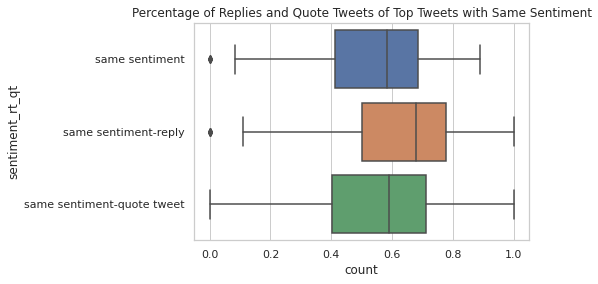

In [ ]:
sns.set_theme(style="whitegrid")
top_tweet_breakdown = sns.boxplot(x=top_tweets_test["count"], y=top_tweets_test["sentiment_rt_qt"]).set(title='Percentage of Replies and Quote Tweets of Top Tweets with Same Sentiment')

In [ ]:
compare = pd.DataFrame()
compare['Type'] = ['Reply', 'Quote Tweet', 'Reply & Quote Tweet']
compare['Percentage over 50%'] = [len(top_tweets_test[(top_tweets_test['sentiment_rt_qt'] == 'same sentiment-reply') & (top_tweets_test['count'] > 0.5 )])/len(top_tweets_test[top_tweets_test['sentiment_rt_qt'] == 'same sentiment-reply']),
                                  len(top_tweets_test[(top_tweets_test['sentiment_rt_qt'] == 'same sentiment-quote tweet') & (top_tweets_test['count'] > 0.5 )])/len(top_tweets_test[top_tweets_test['sentiment_rt_qt'] == 'same sentiment-quote tweet']),
                                  len(top_tweets_test[(top_tweets_test['sentiment_rt_qt'] == 'same sentiment') & (top_tweets_test['count'] > 0.5 )])/len(top_tweets_test[top_tweets_test['sentiment_rt_qt'] == 'same sentiment'])]

compare              

,Type,Percentage over 50%
0,Reply,0.72
1,Quote Tweet,0.62
2,Reply & Quote Tweet,0.62


As you can see above, the sentiments for the replies and the quote tweets of most popular tweets generally follow the same sentiment for more than half of the tweets. The same is also seen for when considering only quote tweets and only replies. However, one consideration we need to take into account is that the tweets are overwhelmingly positive.

In [ ]:
top_tweets['positive sentiment'] = top_tweets.apply(lambda x : get_senti_reply_quote(x['tweet_id'], 'positive'), axis = 1)
top_tweets['positive sentiment-reply'] = top_tweets.apply(lambda x : get_senti_reply(x['tweet_id'], 'positive'), axis = 1)
top_tweets['positive sentiment-quote tweet'] = top_tweets.apply(lambda x : get_senti_quote(x['tweet_id'], 'positive'), axis = 1)

In [ ]:
top_tweets_test = pd.melt(top_tweets[['tweet_index', 'full_text', "sentiment", 'positive sentiment', 'positive sentiment-reply', 'positive sentiment-quote tweet']], id_vars=["tweet_index", "full_text", "sentiment"], var_name="sentiment_rt_qt", value_name="count")
top_tweets_test.head()

,tweet_index,full_text,sentiment,sentiment_rt_qt,count
0,108,DOH PRESS RELEASE\nPR No: 2021-01-13-01\n13 Ja...,positive,positive sentiment,0.500000
1,1381,"Ngayong 4 PM, Abril 2, 2021, ang Department of...",positive,positive sentiment,0.645161
2,639,"Ngayong 4 PM, Abril 1, 2021, ang Department of...",positive,positive sentiment,0.083499
3,1193,"Ngayong 4 PM, Marso 19, 2021, ang Department o...",positive,positive sentiment,0.537037
4,959,"Ngayong 4 PM, Marso 29, 2021, ang Department o...",positive,positive sentiment,0.736842


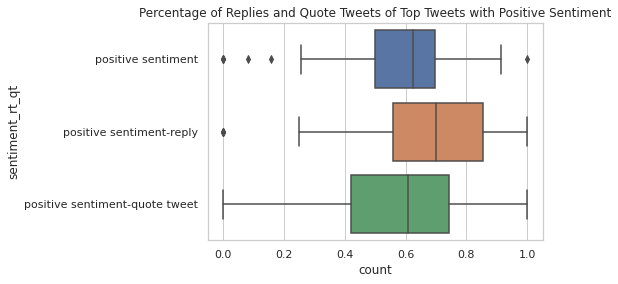

In [ ]:
sns.set_theme(style="whitegrid")
top_tweet_breakdown = sns.boxplot(x=top_tweets_test["count"], y=top_tweets_test["sentiment_rt_qt"]).set(title='Percentage of Replies and Quote Tweets of Top Tweets with Positive Sentiment')

In [ ]:
compare = pd.DataFrame()
compare['Type'] = ['Reply', 'Quote Tweet', 'Reply & Quote Tweet']
compare['Percentage over 50%'] = [len(top_tweets_test[(top_tweets_test['sentiment_rt_qt'] == 'positive sentiment-reply') & (top_tweets_test['count'] > 0.5 )])/len(top_tweets_test[top_tweets_test['sentiment_rt_qt'] == 'positive sentiment-reply']),
                                  len(top_tweets_test[(top_tweets_test['sentiment_rt_qt'] == 'positive sentiment-quote tweet') & (top_tweets_test['count'] > 0.5 )])/len(top_tweets_test[top_tweets_test['sentiment_rt_qt'] == 'positive sentiment-quote tweet']),
                                  len(top_tweets_test[(top_tweets_test['sentiment_rt_qt'] == 'positive sentiment') & (top_tweets_test['count'] > 0.5 )])/len(top_tweets_test[top_tweets_test['sentiment_rt_qt'] == 'positive sentiment'])]

compare       

,Type,Percentage over 50%
0,Reply,0.78
1,Quote Tweet,0.66
2,Reply & Quote Tweet,0.72


When checking the percentage of replies and quote tweets that were positive regardless of the original tweet’s sentiment, we see that the number of tweets that have positive replies and quote tweets more than half the time is greater compared when checking for the same sentiment. This could indicate that replies and quote tweets tend to be positive instead of following the original tweet’s sentiment.

In [ ]:
top_tweets['negative sentiment'] = top_tweets.apply(lambda x : get_senti_reply_quote(x['tweet_id'], 'negative'), axis = 1)
top_tweets['negative sentiment-reply'] = top_tweets.apply(lambda x : get_senti_reply(x['tweet_id'], 'negative'), axis = 1)
top_tweets['negative sentiment-quote tweet'] = top_tweets.apply(lambda x : get_senti_quote(x['tweet_id'], 'negative'), axis = 1)

In [ ]:
top_tweets_test = pd.melt(top_tweets[['tweet_index', 'full_text', "sentiment", 'negative sentiment', 'negative sentiment-reply', 'negative sentiment-quote tweet']], id_vars=["tweet_index", "full_text", "sentiment"], var_name="sentiment_rt_qt", value_name="count")
top_tweets_test.head()

,tweet_index,full_text,sentiment,sentiment_rt_qt,count
0,108,DOH PRESS RELEASE\nPR No: 2021-01-13-01\n13 Ja...,positive,negative sentiment,0.500000
1,1381,"Ngayong 4 PM, Abril 2, 2021, ang Department of...",positive,negative sentiment,0.354839
2,639,"Ngayong 4 PM, Abril 1, 2021, ang Department of...",positive,negative sentiment,0.916501
3,1193,"Ngayong 4 PM, Marso 19, 2021, ang Department o...",positive,negative sentiment,0.462963
4,959,"Ngayong 4 PM, Marso 29, 2021, ang Department o...",positive,negative sentiment,0.263158


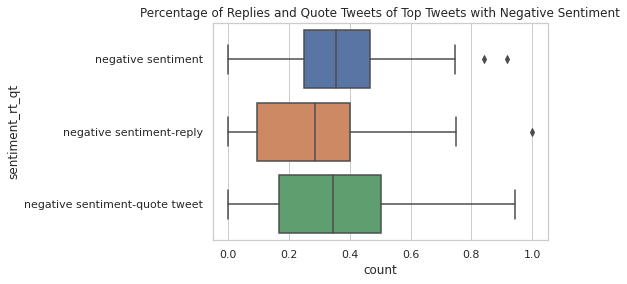

In [ ]:
sns.set_theme(style="whitegrid")
top_tweet_breakdown = sns.boxplot(x=top_tweets_test["count"], y=top_tweets_test["sentiment_rt_qt"]).set(title='Percentage of Replies and Quote Tweets of Top Tweets with Negative Sentiment')

In [ ]:
compare = pd.DataFrame()
compare['Type'] = ['Reply', 'Quote Tweet', 'Reply & Quote Tweet']
compare['Percentage over 50%'] = [len(top_tweets_test[(top_tweets_test['sentiment_rt_qt'] == 'negative sentiment-reply') & (top_tweets_test['count'] > 0.5 )])/len(top_tweets_test[top_tweets_test['sentiment_rt_qt'] == 'negative sentiment-reply']),
                                  len(top_tweets_test[(top_tweets_test['sentiment_rt_qt'] == 'negative sentiment-quote tweet') & (top_tweets_test['count'] > 0.5 )])/len(top_tweets_test[top_tweets_test['sentiment_rt_qt'] == 'negative sentiment-quote tweet']),
                                  len(top_tweets_test[(top_tweets_test['sentiment_rt_qt'] == 'negative sentiment') & (top_tweets_test['count'] > 0.5 )])/len(top_tweets_test[top_tweets_test['sentiment_rt_qt'] == 'negative sentiment'])]

compare       

,Type,Percentage over 50%
0,Reply,0.12
1,Quote Tweet,0.26
2,Reply & Quote Tweet,0.16


Conversely, when looking at the percentage of replies and quote tweets that were negative regardless of the original tweet’s sentiment, we see that the number of tweets that have positive replies and quote tweets more than half the time is much less compared when checking for the same sentiment. This corroborates with the previous insight that replies and quote tweets tend to be positive instead of following the original tweet’s sentiment.

#Conclusion

From our exploratory data analysis, we found out that the tweets by the Department of Health of the Philippines are perceived quite well by fellow Filipinos. As DOH is one of the — if not, the leading— sources of health information, it would indeed be a good thing if they are looked at positively by their target audience and are sought after for health information. In terms of tweet content, the effects of the pandemic are seen with how the majority of DOH’s tweets are about COVID-19. Having photos — such as info-graphics — seem to be a trend that helps with increasing engagement and popularity with the public. Overall, our endeavour has yielded insightful results regarding the relationship between health organizations such as DOH, Twitter, and the users.